In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import copy
import pickle
import numpy as np
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import sim
import plot
import pad

# Patient properties + model predictions
PATH_TO_INPUT_FOLDER = '../secure/pad/'
PATH_TO_OUTPUT_FOLDER = '../secure/pad/output/'
PATH_TO_DL_MODEL = os.path.join(PATH_TO_INPUT_FOLDER, 'dl.csv')
PATH_TO_RF_MODEL = os.path.join(PATH_TO_INPUT_FOLDER, 'rf.csv')
PATH_TO_LR_MODEL = os.path.join(PATH_TO_INPUT_FOLDER, 'lr.csv')
PATH_TO_MERGED_MODEL = os.path.join(PATH_TO_INPUT_FOLDER, 'merged.csv')
PATH_TO_PATIENT_PROPERTIES = os.path.join(PATH_TO_INPUT_FOLDER, 'properties.csv')

# Workflows
PATH_TO_NURSE_YAML = '../workflows/pad_nurse.yaml'
PATH_TO_DOCTOR_YAML = '../workflows/pad_doctor.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Conceptual Overview

### Simulation

We use discrete event simulation to simulate our clinical workflow $W$. 

In other words, we represent the world as occuring through a set of discrete, evenly spaced timesteps $\lambda = 0, 1,...,N$. Each timestep $\lambda$ could represent a second, minute, hour, day, etc., the interpretation is up to the user.

Events $A$ and $B$ that occur within the same timestep $\lambda$ can have arbitrary ordering if there does not exist a strict $A \rightarrow B$ or $B \rightarrow A$ dependency between these events. In other words, if 3 patients have an MRI and 2 patients have a blood test on timestep $\lambda = 3$, then assuming none of these events are dependent on each other, the ordering in which the blood tests and MRIs occur will be random.

A **"duration"** refers to a number of timesteps (i.e. a length of time).

### Workflow
A workflow $W$ is simply a set of states $S$.

### States
Each state $s \in S$ has associated with it:
1. A duration $\lambda_s$ representing how many timesteps an agent will wait in this state before transitioning to another state
2. A set of utilities $U_s$
3. A set of resource deltas $R_s \subseteq R$ that specify how various resources $r \in R_s$ change when an agent arrives at this state
4. A set of transitions $T_s \subseteq T$
5. A type $\tau_s \in \{\text{start}, \text{normal}, \text{end}\}$. 

Invariants:
* $|\{ s \in S | \tau_s = \text{start} \}| = 1$
* $ \forall s \in S$ such that $\tau_s = \text{start}, |T_s| > 0$
* $ \forall s \in S$ such that $\tau_s = \text{normal}, |T_s| > 0$
* $ \forall s \in S$ such that $\tau_s = \text{end}, |T_s| = 0$

### Transitions
Given the set of all transitions $T$, each transition $t \in T_s \subseteq T$ has associated with it:
1. A source state $s \in S$
1. A destination state $s' \in S$ (where $s'$ could be the same as $s$)
1. A duration $\lambda_t$ representing how many timesteps an agent will wait, after having chosen this transition $t$, before moving to state $s'$
2. A condition $c_t \in C$ that, only when TRUE, allows the agent to take this transition $t$ to state $s'$
2. A set of utilities $U_t$
3. A set of resource deltas $R_t \subseteq R$ that specify how various resources $r \in R_t$ change after an agent takes this transition

### Utilities
Given the set of all utilities $U$, each utility $u \in U$ has associated with it:
1. A value $u_v \in \mathbb{R}$ representing the numeric value of this utility
1. A unit $u_u$ (i.e. QALYs, US dollars, years, etc.)
1. A condition $c_u \in C$ that, only when TRUE, has the simulation record that this utility value $u_v$ for unit $u_u$ was achieved

### Conditions
A condition $c \in C$ determines whether a utility or transition can be taken. A condition $c$ can take the form of either:
1. A probability (in which case $\{ c \in \mathbb{R} | 0 \le c \le 1 \}$); OR
1. An arbitrary Python expression which evaluates to TRUE or FALSE

### Resources
A resource $r \in R$ is a constrained resource that is shared across all patients. This represents a hospital-level constraint of a workflow (i.e. fiscal budget, number of nurses, MRI machine availability, etc.). Each resource $r$ has associated with it:
1. A level $r_l \in \mathbb{N}$ which represents the current value of the resource
1. An initial amount $r_i \in \mathbb{N}$ which ensures $r_l = r_i$ when $\lambda = 0$
1. An maximum capacity $r_m \in \mathbb{N}$ which ensures that $r_l \le r_m$
1. A refill amount $r_a \in \mathbb{N}$ that represents how much this resource gets increased after $\lambda_r$ timesteps have elapsed since the last refill
1. A refill duration $\lambda_r \in \mathbb{N}$ that represents how many timesteps must elapse before the resource is increased to a value of $\max{r_l + r_a, r_m}$

**!! Important Note !!** In order to decrement a resource, you need to specify a **resource delta** on the relevant state/transition. Otherwise, if you just require that `nurse_capacity > 0` for a transition, then the simulation will not automatically decrement `nurse_capacity` by 1 when that transition is taken (which can be surprising to some users). This is often a cause of infinite loops, or situations where changing the $r_i$, $r_m$, or $r_a$ of a resource has no effect on the model's achieved utility.

### Patients
Each patient $p \in P$ has associated with it:
1. A start timestep $\lambda_p$ representing the timestep of the simulation at which the patient began progressing through the workflow (i.e. the day that the patient was admitted to the hospital)
1. A current state $s_p \in S$. The patient always starts at a state $s_p$ where $\tau_{s_p} = \text{start}$
2. A set of **properties** $\Rho_p$ which can be anything (integers, floats, strings, dictionaries, lists, etc.)
3. A **history** object $H_p$ which captures all of the past states, transitions, and utilities that the patient achieved.

## Running a Simulation

Each patient $p$ starts his/her workflow at the state $s$, where $\tau_s = \text{start}$. Note: This is the same for all patients

Each patient $p$ starts his/her workflow at timestep $\lambda_p$. Note: This varies across all patients.

Each patient $p$ then progresses through the states of the workflow, according to the applicable transitions and conditions. The patient stops their journey when either of the following conditions are met:
* The patient reaches a state $s$ where $\tau_s = \text{end}$; OR
* The simulation is terminated prematurely after a set number of timesteps have occured

# Create the Workflow

We use a **YAML** file to specify our ACP workflow.

In this YAML file, we include all of the states, transitions, utilities, and variables relevant to the workflow that we want to simulate.

An example file can be found in `workflows/pad_doctor.yaml` and `workflows/pad_nurse.yaml`.

The schema for creating these YAML files for arbitrary workflows can be found in `workflows/schema.yaml`

# Patients

In [2]:
df_merged = pad.generate_csv(PATH_TO_DL_MODEL, PATH_TO_RF_MODEL, PATH_TO_LR_MODEL, PATH_TO_PATIENT_PROPERTIES)

---- Read ----
Size: df_dl = (5082, 4) df_rf = (34344, 3) df_lr = (12474, 3)
---- De-duplicate ----
Removed 563 repeated rows in df_dl
Removed 14388 repeated rows in df_rf
Removed 3300 repeated rows in df_lr
Size: df_dl = (4519, 3) df_rf = (19956, 3) df_lr = (9174, 3)
---- Merge ----
# of overlapping patients btwn df_dl and df_rf: 4519
# of overlapping patients btwn df_dl and df_lr: 4478
# of overlapping patients btwn df_lr and df_rf: 9174
Removed 26 rows in df_merged with conflicting 'y' labels
Size: df_merged = (4452, 5)
---- ABI Test ----
ABI sensitivity @ 0.9: 0.9513201320132013
ABI specificity @ 0.9: 0.962037037037037
---- Set Random Nonce for Resource Priority ----
---- Stats ----
Prevalence of PAD: 0.2722371967654987
P(ABI < 0.4| PAD): 0.04372937293729373
P(ABI < 0.45| PAD): 0.09075907590759076
P(ABI < 0.5| PAD): 0.15759075907590758
P(ABI < 0.55| PAD): 0.2590759075907591
P(ABI < 0.6| PAD): 0.3778877887788779
P(ABI < 0.65| PAD): 0.5099009900990099
P(ABI < 0.7| PAD): 0.64851485148

# Model Settings

In [3]:
THRESHOLDS = np.linspace(0, 1, 101)
MODELS = ['dl', 'rf', 'lr',]

# Nurse-Driven Workflow

### Workflow

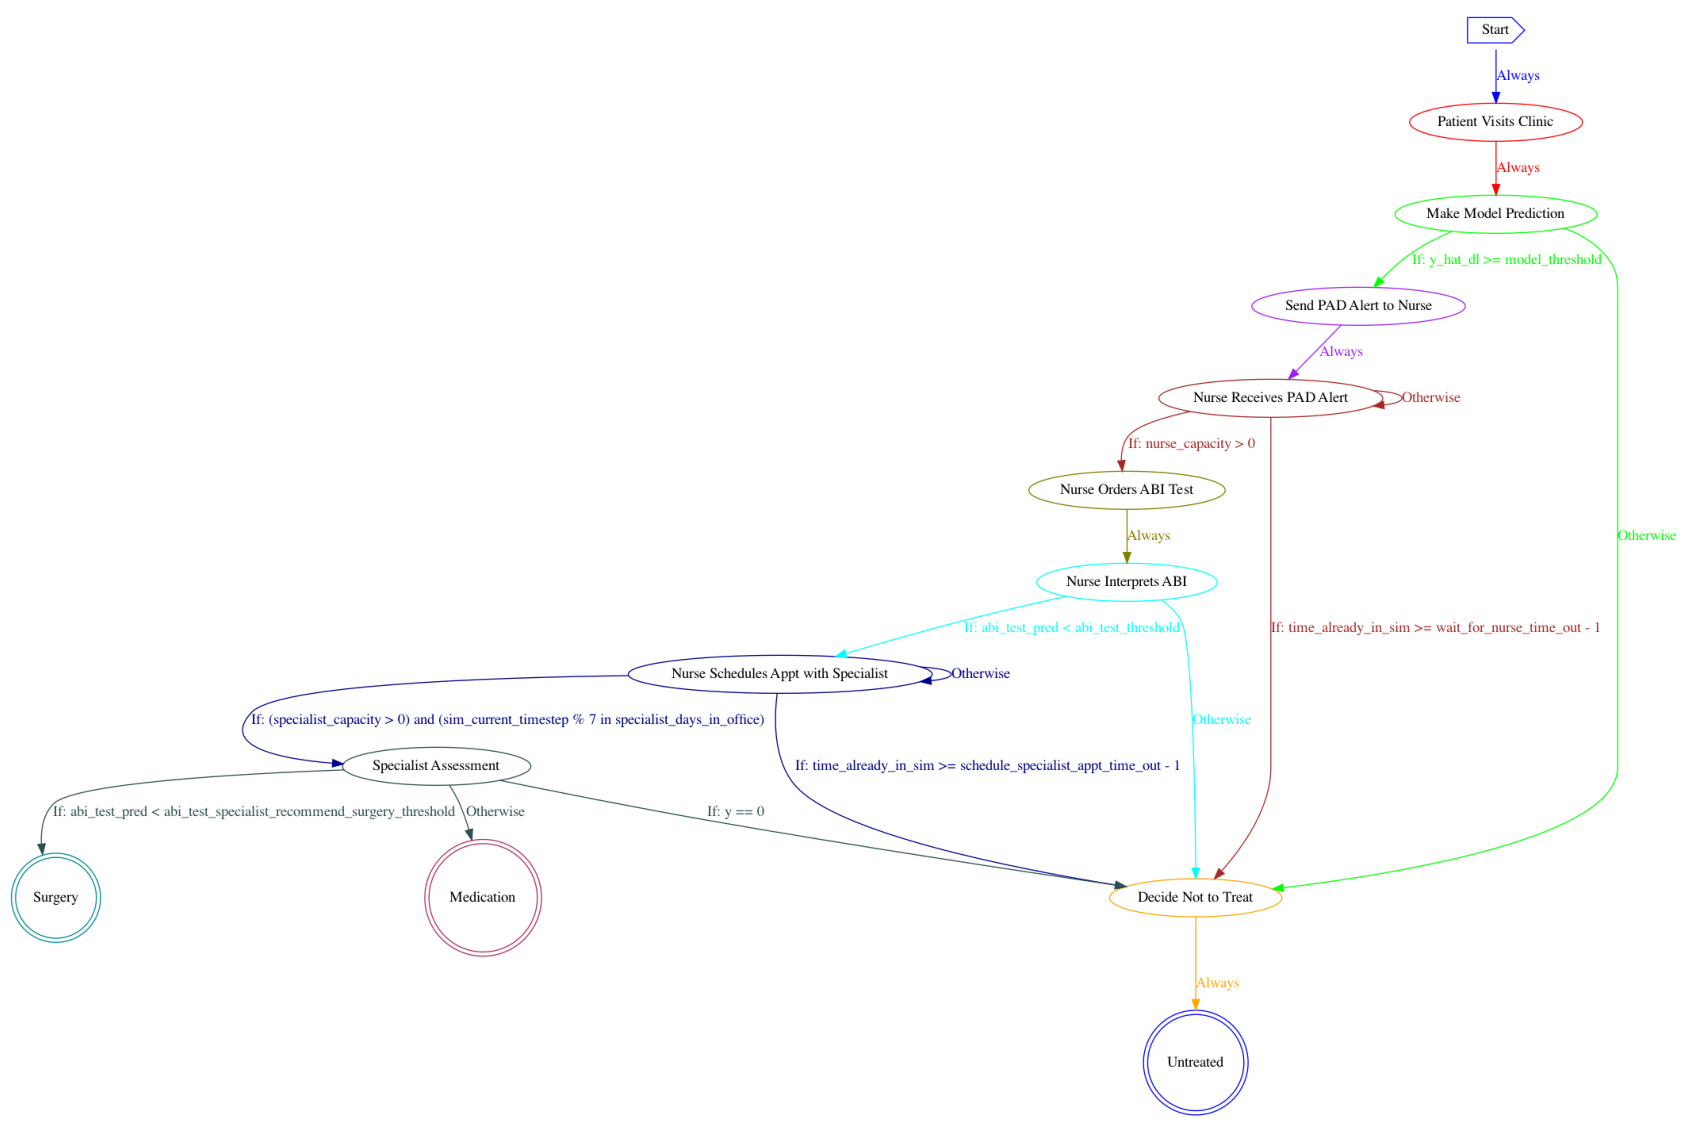

In [4]:
simulation = pad.load_simulation(PATH_TO_NURSE_YAML, PATH_TO_PATIENT_PROPERTIES)
simulation.draw_workflow_diagram(figsize=(30,30))

### Patients

Note: this can be reused for doctor workflow b/c they have the same set of patient properties

In [5]:
all_patients = pad.generate_patient_list(simulation, mean_admits_per_day=35, num_days=500)
all_patients[0].properties

{'abi_test_pred': 0.693035673200502,
 'y': 1.0,
 'y_hat_dl': 0.94534182548523,
 'y_hat_rf': 1.0,
 'y_hat_lr': 0.2922487323034018,
 'random_resource_priority': 3770.0}

### Simulate Workflow

In [6]:
def simulate_nurse_workflow(patients: list[sim.Patient],
                            values: list,
                            specialist_capacity: int = None,
                            is_ranked_screening: bool = True,
                            path_to_yaml: str = None):
    values += [ 1e5, ] # 1e5 represents the optimistic case
    
    # Cache results
    pkl_name: str = ("nurse_" +
                     str(is_ranked_screening) + "_" +
                     str(specialist_capacity) + "_" +
                     "-".join([str(x) for x in values]) + "_" +
                     str(len(patients)) + "_" +
                     os.path.basename(path_to_yaml).split('.')[0] + "_" + 
                     ".pkl")
    pkl_path: str = os.path.join(PATH_TO_OUTPUT_FOLDER, pkl_name)
    if os.path.exists(pkl_path):
        print(f"Loading file from {pkl_path}")
        with open(pkl_path, 'rb') as fd:
            results = pickle.load(fd)
        model_2_result, baseline_2_result = results['model'], results['baseline']
    else:
        print(f"Didn't find {pkl_path}, recreating from scratch")
        labels = [f"{x}" for x in values]
        settings = [{
            'nurse_capacity': {
                'init_amount': x,
                'max_amount': x,
                'refill_amount': x,
                'type': 'resource',
                'refill_duration': 1,
            },
            'specialist_capacity': {
                'type': 'resource',
                'init_amount': specialist_capacity if specialist_capacity else 1e5,
                'max_amount': specialist_capacity if specialist_capacity else 1e5,
                'refill_amount': specialist_capacity if specialist_capacity else 1e5,
                'refill_duration': 1,
            },
        } for x in values]
        model_2_result, baseline_2_result = pad.run_test(patients,
                                                         labels,
                                                         settings,
                                                         MODELS,
                                                         THRESHOLDS,
                                                         path_to_yaml,
                                                         PATH_TO_PATIENT_PROPERTIES,
                                                         is_patient_sort_by_y_hat=is_ranked_screening,
                                                         func_setup_optimistic=pad.setup_nurse_optimistic)
        with open(pkl_path, 'wb') as fd:
            pickle.dump({
                'model': model_2_result,
                'baseline': baseline_2_result,
            }, fd)

    # Plotting constants
    df_ = pad.plot_helper(model_2_result, {
        'all': baseline_2_result['all'],
        'none': baseline_2_result['none']
    }).rename(columns={'model': 'color'})
    # Use 1e5 as the 'optimistic' case for nurse capacity
    df_ = df_[df_['label'] != 'optimistic']
    df_.loc[df_['label'] == '100000.0', 'label'] = 'optimistic'
    label_sort_order: list[str] = [ str(x) for x in df_['label'].unique() ]
    label_title: str = 'Nurse Capacity'

    for m in MODELS:
        model_2_result[m] = model_2_result[m][model_2_result[m]['label'] != 'optimistic']
        model_2_result[m].loc[model_2_result[m]['label'] == '100000.0', 'label'] = 'optimistic'
        
    # Ribbon plot
    p1 = plot.plot_mean_utility_v_threshold('Deep Learning', model_2_result['dl'],
                                            label_sort_order=label_sort_order,
                                            label_title=label_title)
    p2 = plot.plot_mean_utility_v_threshold('Random Forest', model_2_result['rf'],
                                            label_sort_order=label_sort_order,
                                            label_title=label_title)
    p3 = plot.plot_mean_utility_v_threshold('Logistic Regression', model_2_result['lr'],
                                            label_sort_order=label_sort_order,
                                            label_title=label_title)
    print(p1)
    print(p2)
    print(p3)

    # Dodged bar plot
    screening_name: str = 'ranked screening' if is_ranked_screening else 'thresholded screening'
    p = plot.plot_dodged_bar_mean_utilities(f'Utility of nurse-driven workflow with {screening_name}',
                                            df_,
                                            label_sort_order=label_sort_order,
                                            color_sort_order=[
                                                'none', 'all', 'lr', 'rf', 'dl', ],
                                            color_names=[
                                                'Treat\nNone', 'Treat\nAll', 'Logistic\nRegression', 'Random\nForest', 'Deep\nLearning'
                                            ],
                                            is_percent_of_optimistic=1,
                                            x_label=label_title)

    print(p)


==== Ranked + Specialist Unlimited ====
Loading file from ../secure/pad/output/nurse_True_None_0-1-2-3-4-5-6-7-8-9-10-100000.0_17515_pad_nurse_.pkl


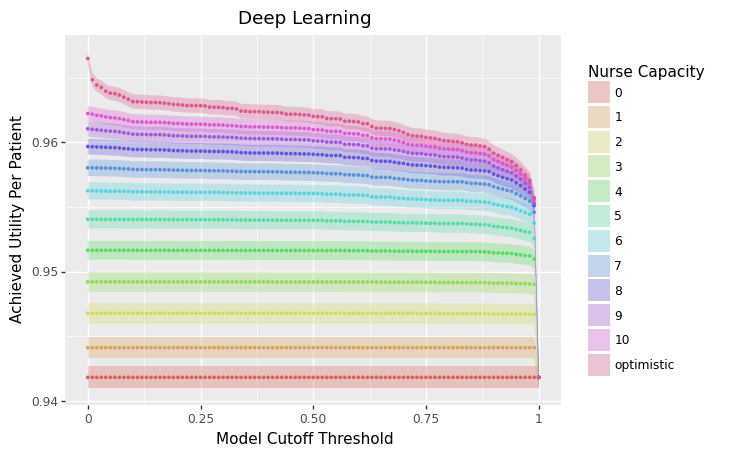

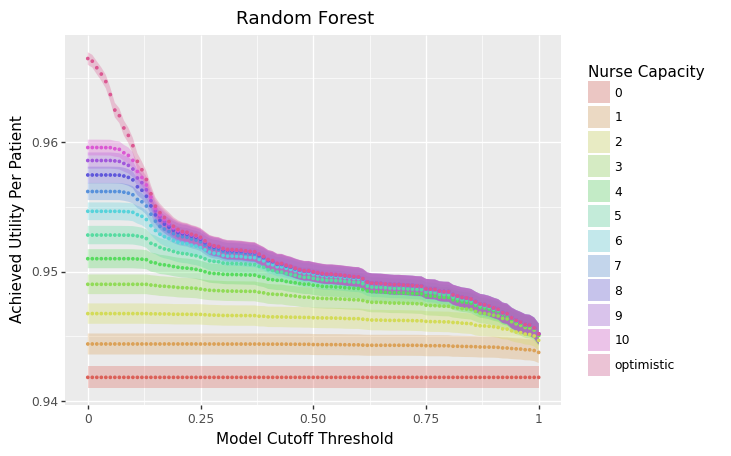

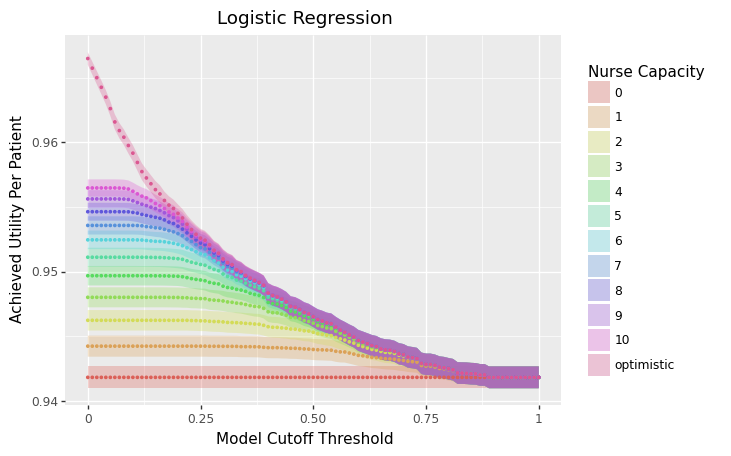

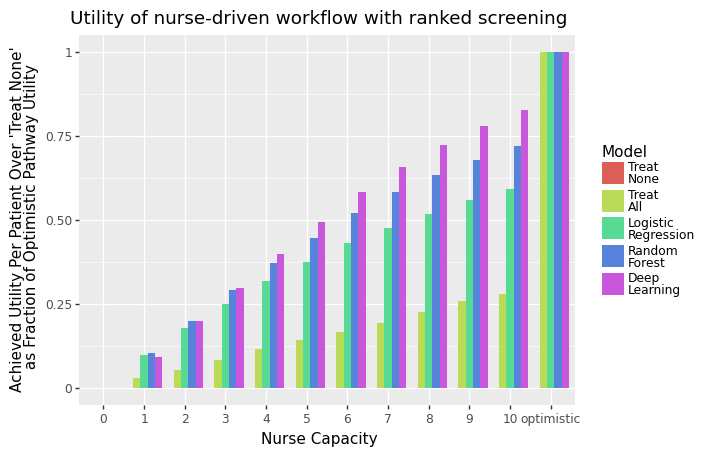


==== Thresholded + Specialist Unlimited ====
Loading file from ../secure/pad/output/nurse_False_None_0-1-2-3-4-5-6-7-8-9-10-100000.0_17515_pad_nurse_.pkl


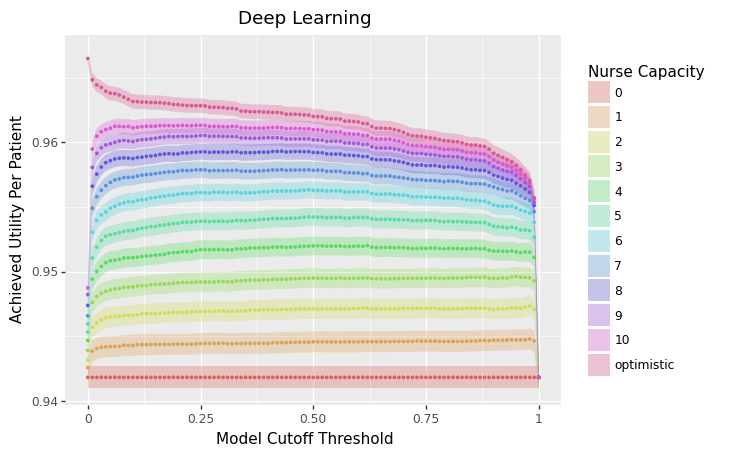

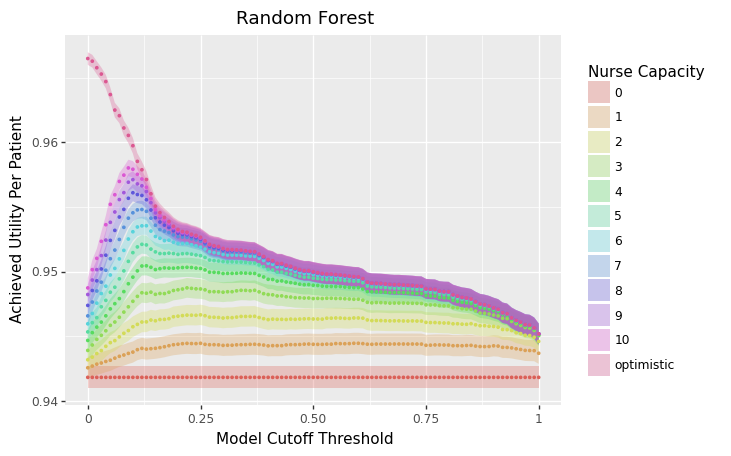

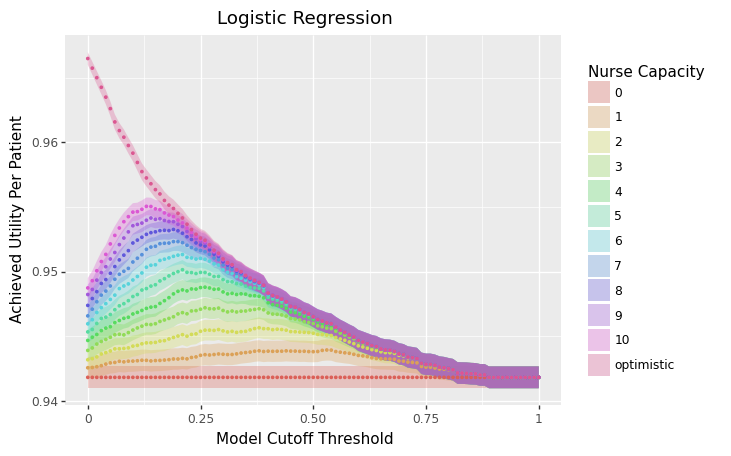

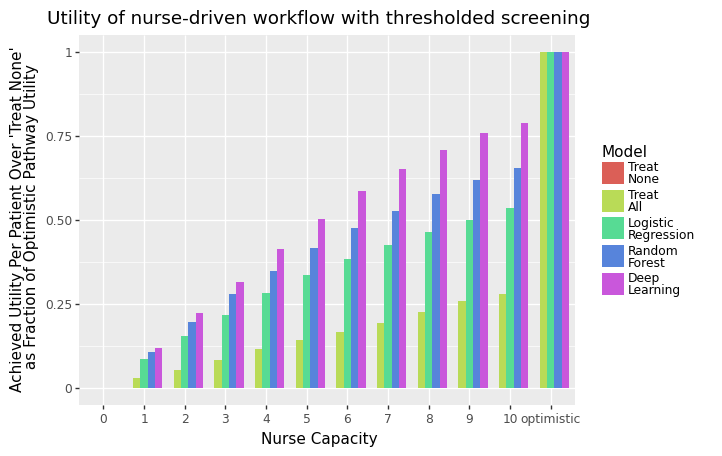


==== Ranked + Specialist Cap (2) ====
Loading file from ../secure/pad/output/nurse_True_2_0-1-2-3-4-5-6-7-8-9-10-100000.0_17515_pad_nurse_.pkl


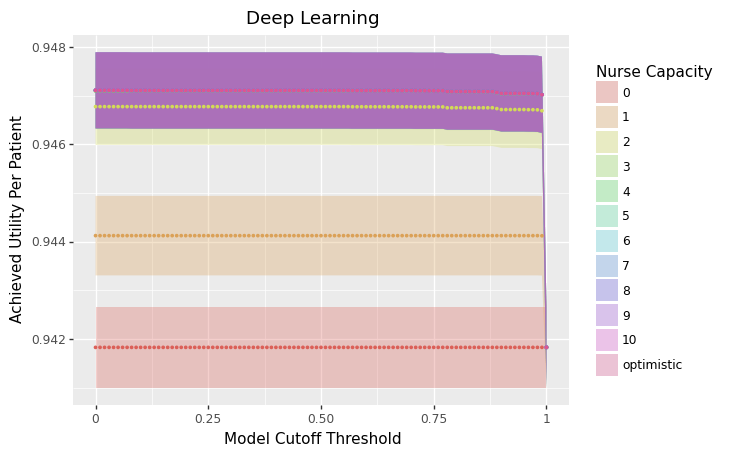

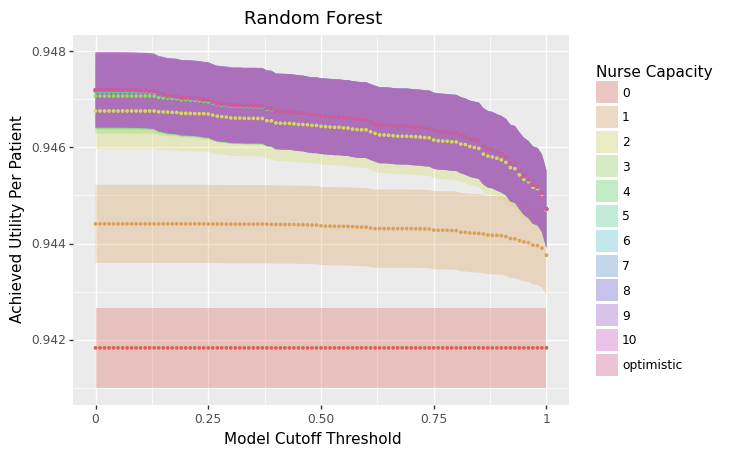

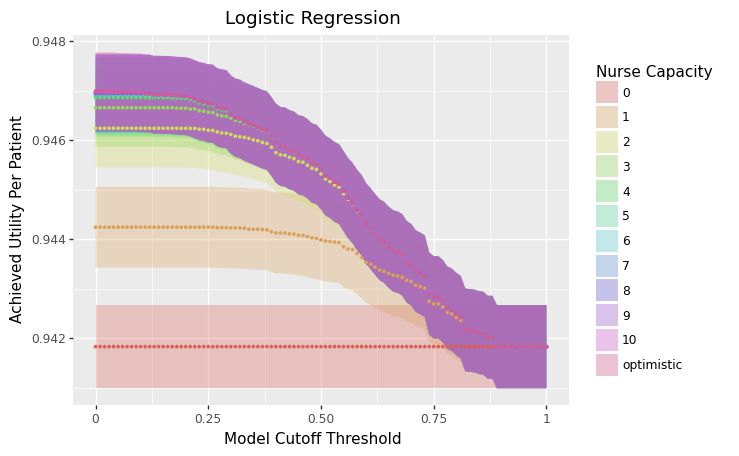

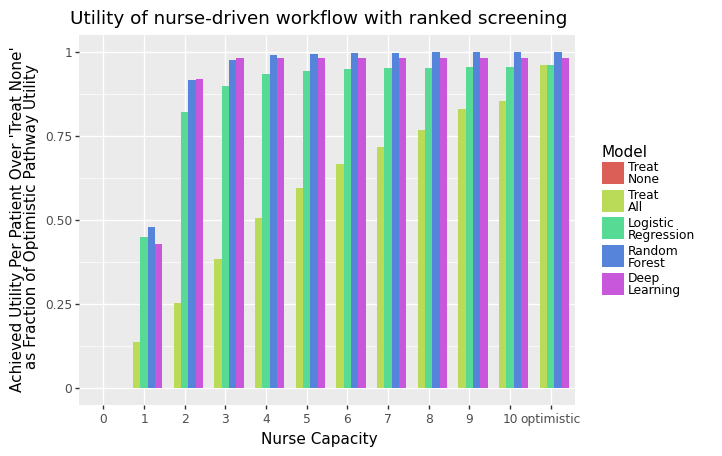


==== Threshold + Specialist Cap (2) ====
Loading file from ../secure/pad/output/nurse_False_2_0-1-2-3-4-5-6-7-8-9-10-100000.0_17515_pad_nurse_.pkl


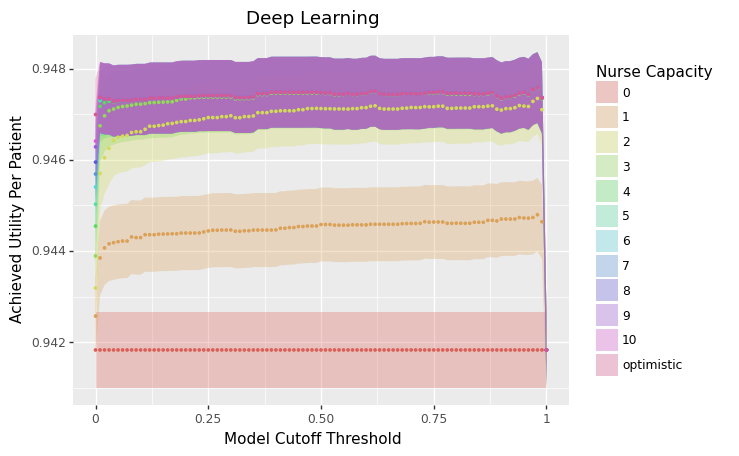

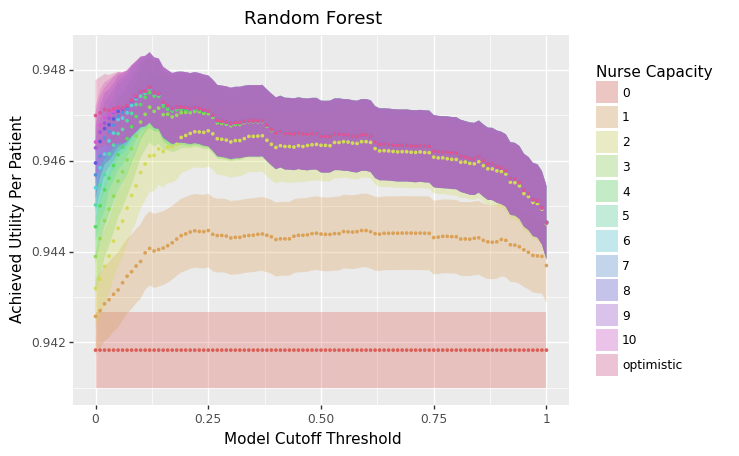

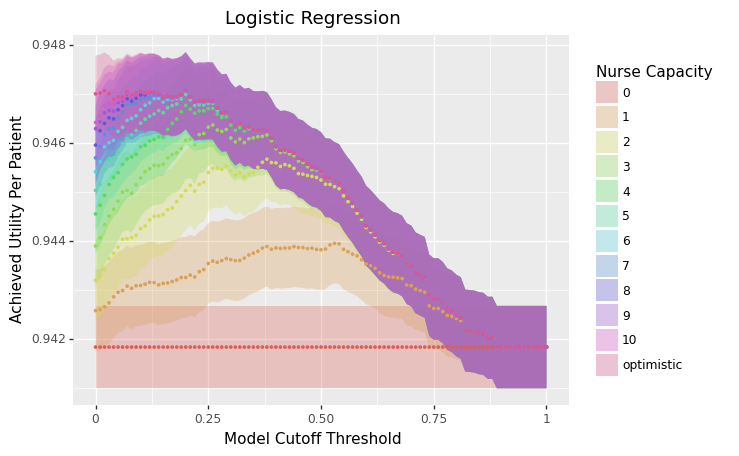

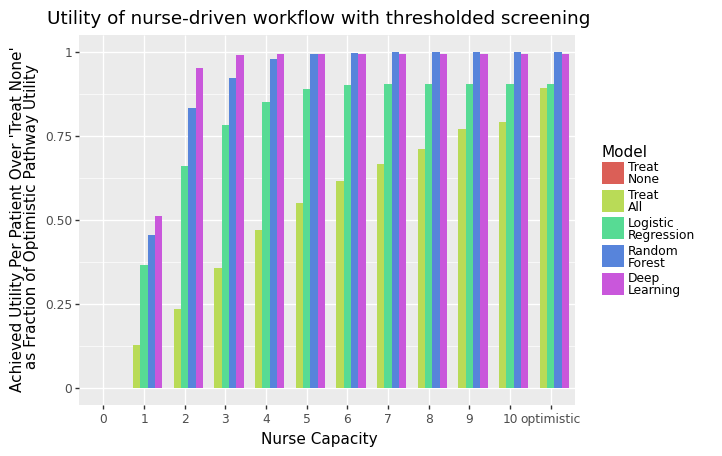


==== Ranked + Specialist Cap (5) ====
Loading file from ../secure/pad/output/nurse_True_5_0-1-2-3-4-5-6-7-8-9-10-100000.0_17515_pad_nurse_.pkl


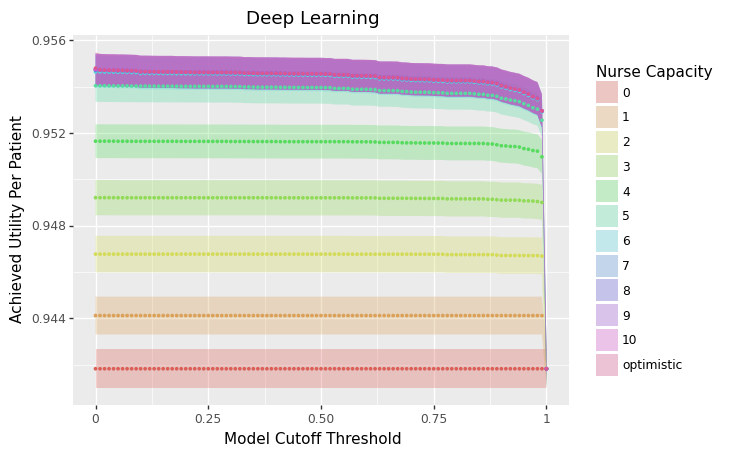

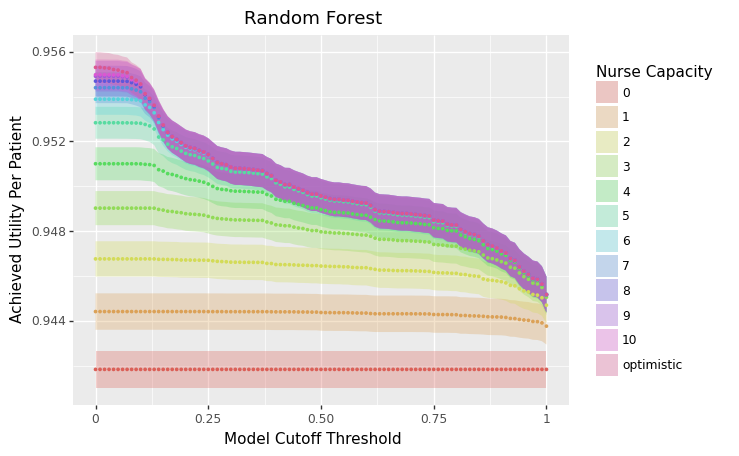

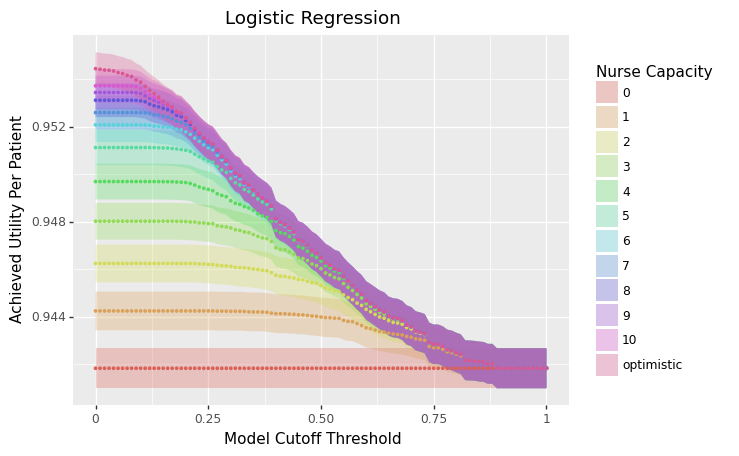

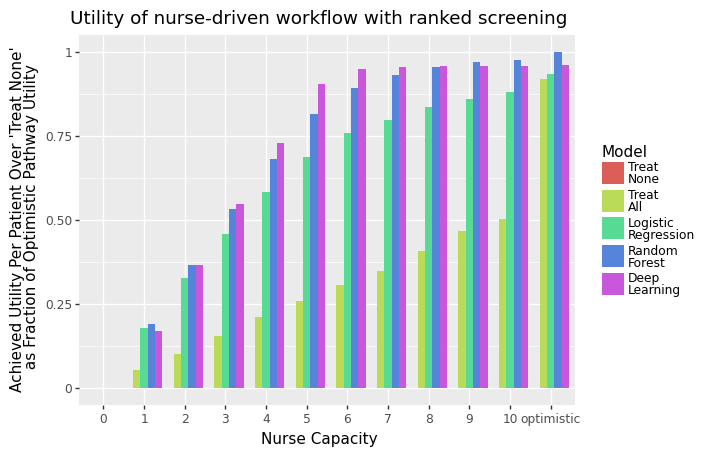


==== Threshold + Specialist Cap (5) ====
Loading file from ../secure/pad/output/nurse_False_5_0-1-2-3-4-5-6-7-8-9-10-100000.0_17515_pad_nurse_.pkl


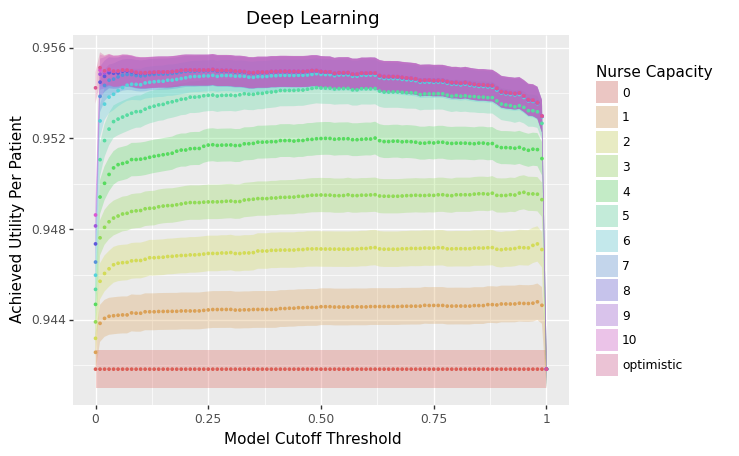

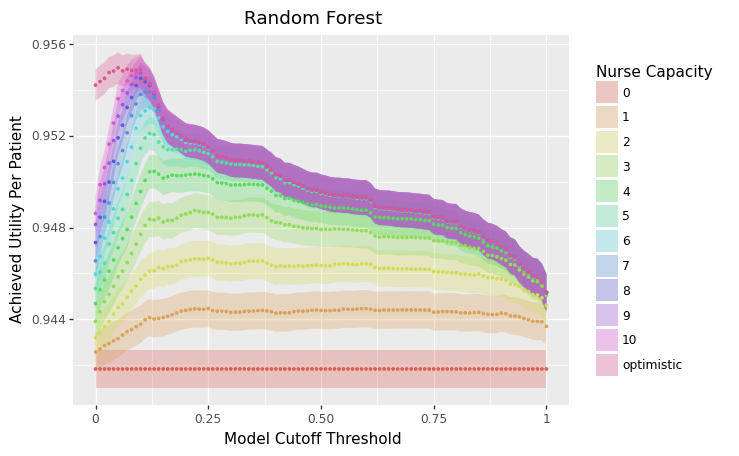

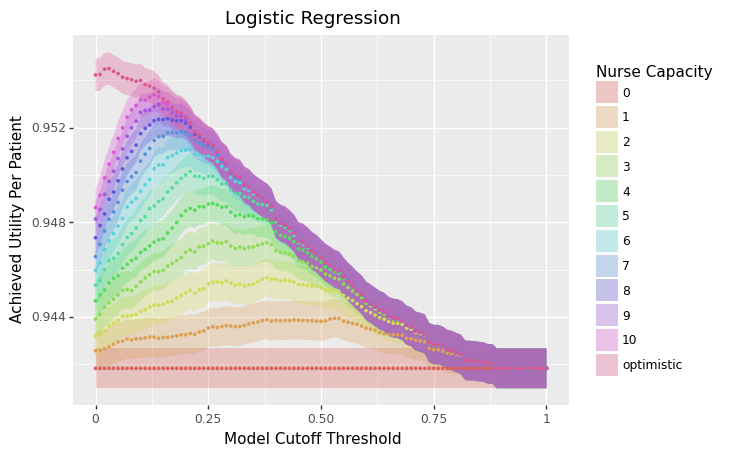

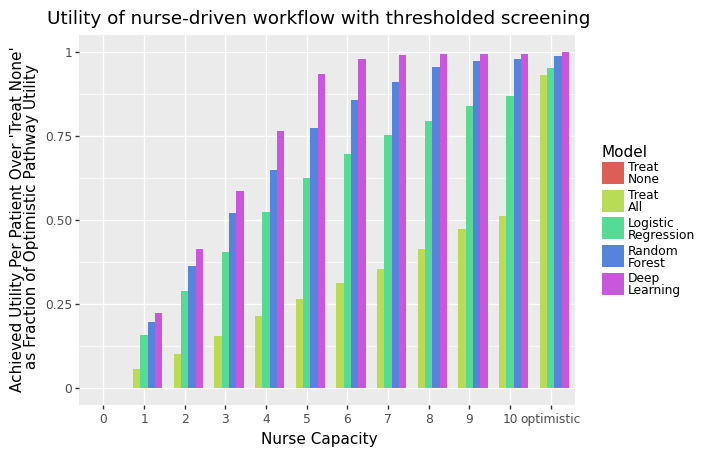

In [9]:
# Ranked screening, unlimited specialist
print("==== Ranked + Specialist Unlimited ====")
simulate_nurse_workflow(copy.deepcopy(all_patients),
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ],
                        specialist_capacity=None,
                        is_ranked_screening=True,
                        path_to_yaml=PATH_TO_NURSE_YAML)

# Thresholded screening, unlimited specialist
print("==== Thresholded + Specialist Unlimited ====")
simulate_nurse_workflow(copy.deepcopy(all_patients),
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ],
                        specialist_capacity=None,
                        is_ranked_screening=False,
                        path_to_yaml=PATH_TO_NURSE_YAML)

# Ranked screening, capped specialist
print("==== Ranked + Specialist Cap (2) ====")
simulate_nurse_workflow(copy.deepcopy(all_patients),
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ],
                        specialist_capacity=2,
                        is_ranked_screening=True,
                        path_to_yaml=PATH_TO_NURSE_YAML)

# Thresholded screening, capped specialist
print("==== Threshold + Specialist Cap (2) ====")
simulate_nurse_workflow(copy.deepcopy(all_patients),
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ],
                        specialist_capacity=2,
                        is_ranked_screening=False,
                        path_to_yaml=PATH_TO_NURSE_YAML)

# Ranked screening, capped specialist
print("==== Ranked + Specialist Cap (5) ====")
simulate_nurse_workflow(copy.deepcopy(all_patients),
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ],
                        specialist_capacity=5,
                        is_ranked_screening=True,
                        path_to_yaml=PATH_TO_NURSE_YAML)

# Thresholded screening, capped specialist
print("==== Threshold + Specialist Cap (5) ====")
simulate_nurse_workflow(copy.deepcopy(all_patients),
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ],
                        specialist_capacity=5,
                        is_ranked_screening=False,
                        path_to_yaml=PATH_TO_NURSE_YAML)

# Doctor-Driven Workflow

### Workflow

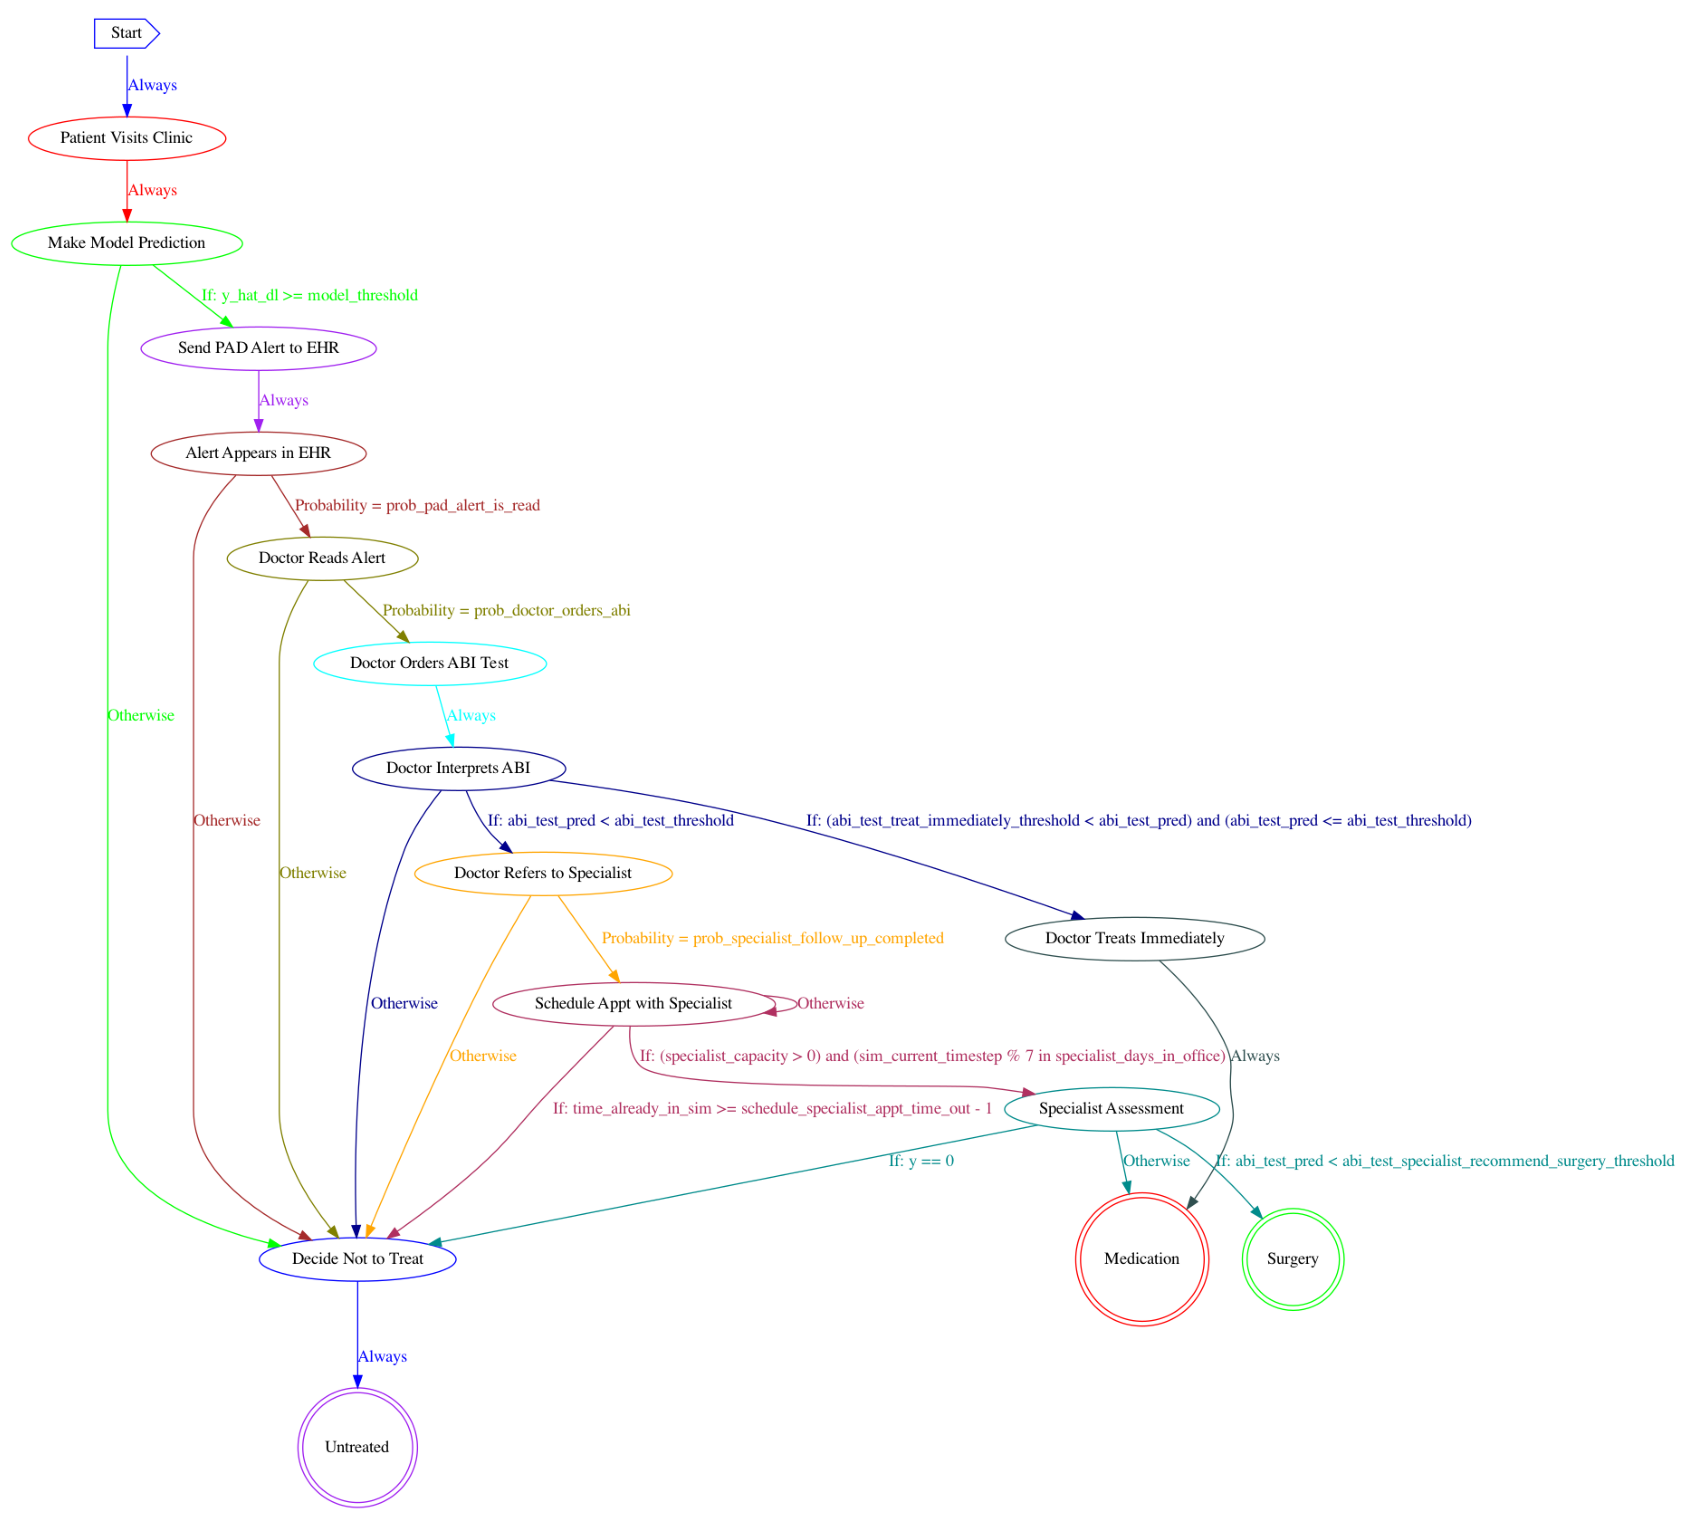

In [10]:
simulation = pad.load_simulation(PATH_TO_DOCTOR_YAML, PATH_TO_PATIENT_PROPERTIES)
simulation.draw_workflow_diagram(figsize=(30,30))

### Simulate Workflow

In [11]:
def simulate_doctor_workflow(patients: list[sim.Patient],
                            values: list,
                            specialist_capacity: int = None,
                            is_ranked_screening: bool = True,
                            path_to_yaml: str = None):
    pkl_name: str = ("doctor_" +
                     str(is_ranked_screening) + "_" +
                     str(specialist_capacity) + "_" +
                     "-".join([str(x) for x in values]) + "_" +
                     str(len(patients)) + "_" +
                     os.path.basename(path_to_yaml).split('.')[0] + "_" + 
                     ".pkl")
    pkl_path: str = os.path.join(PATH_TO_OUTPUT_FOLDER, pkl_name)
    if os.path.exists(pkl_path):
        print(f"Loading file from {pkl_path}")
        with open(pkl_path, 'rb') as fd:
            results = pickle.load(fd)
        model_2_result, baseline_2_result = results['model'], results['baseline']
    else:
        print(f"Didn't find {pkl_path}, recreating from scratch")
        labels = [f"{x}" for x in values]
        settings = [{
            'prob_pad_alert_is_read': {
                'type': 'scalar',
                'value': x,
            },
            'specialist_capacity': {
                'type': 'resource',
                'init_amount': specialist_capacity if specialist_capacity else 1e5,
                'max_amount': specialist_capacity if specialist_capacity else 1e5,
                'refill_amount': specialist_capacity if specialist_capacity else 1e5,
                'refill_duration': 1,
            },
        } for x in values]
        model_2_result, baseline_2_result = pad.run_test(patients,
                                                         labels,
                                                         settings,
                                                         MODELS,
                                                         THRESHOLDS,
                                                         path_to_yaml,
                                                         PATH_TO_PATIENT_PROPERTIES,
                                                         is_patient_sort_by_y_hat=is_ranked_screening,
                                                         func_setup_optimistic=pad.setup_doctor_optimistic)
        with open(pkl_path, 'wb') as fd:
            pickle.dump({
                'model': model_2_result,
                'baseline': baseline_2_result,
            }, fd)

    # Plotting constants
    df_ = pad.plot_helper(model_2_result, {
        'all': baseline_2_result['all'],
        'none': baseline_2_result['none']
    }, threshold=0.5).rename(columns={'model': 'color'})
    # Use prob=1 as the 'optimistic' case
    df_ = df_[df_['label'] != 'optimistic']
    df_.loc[df_['label'] == '1', 'label'] = 'optimistic'
    label_sort_order: list[str] = [ str(x) for x in df_['label'].unique() ]
    label_title: str = 'Probability Doctor Reads Alert'
    for m in MODELS:
        model_2_result[m] = model_2_result[m][model_2_result[m]['label'] != 'optimistic']
        model_2_result[m].loc[model_2_result[m]['label'] == '1', 'label'] = 'optimistic'

    # Ribbon plot
    p1 = plot.plot_mean_utility_v_threshold('Deep Learning', model_2_result['dl'],
                                            label_sort_order=label_sort_order,
                                            label_title=label_title)
    p2 = plot.plot_mean_utility_v_threshold('Random Forest', model_2_result['rf'],
                                            label_sort_order=label_sort_order,
                                            label_title=label_title)
    p3 = plot.plot_mean_utility_v_threshold('Logistic Regression', model_2_result['lr'],
                                            label_sort_order=label_sort_order,
                                            label_title=label_title)
    print(p1)
    print(p2)
    print(p3)

    # Dodged bar plot
    p = plot.plot_dodged_bar_mean_utilities(f'Utility of doctor-driven workflow',
                                            df_,
                                            label_sort_order=label_sort_order,
                                            color_sort_order=[
                                                'none', 'all', 'lr', 'rf', 'dl', ],
                                            color_names=[
                                                'Treat\nNone', 'Treat\nAll', 'Logistic\nRegression', 'Random\nForest', 'Deep\nLearning'
                                            ],
                                            is_percent_of_optimistic=1,
                                            x_label=label_title)

    print(p)


==== Thresholded + Specialist Unlimited ====
Loading file from ../secure/pad/output/doctor_False_None_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_pad_doctor_.pkl


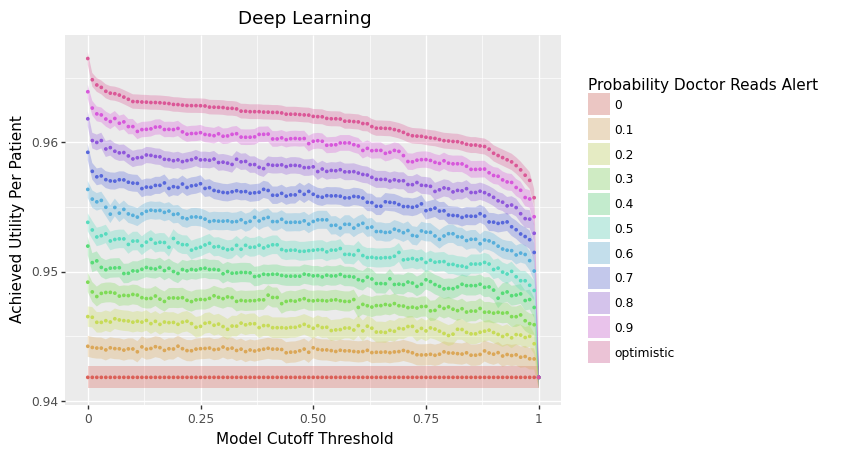

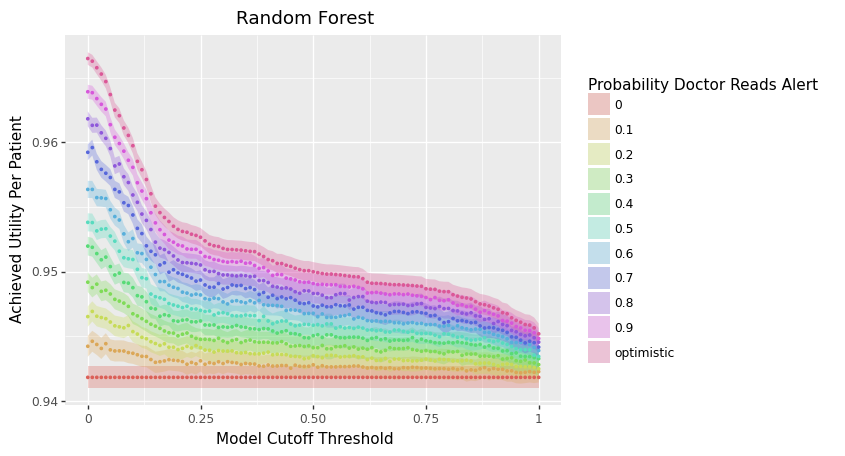

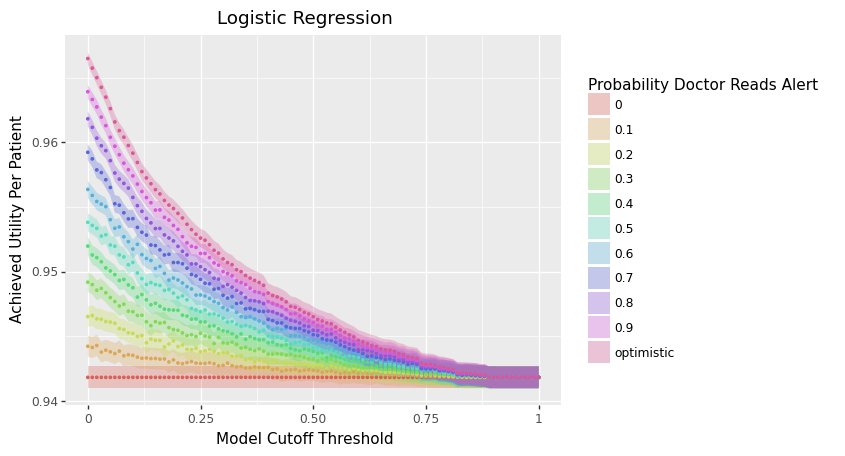

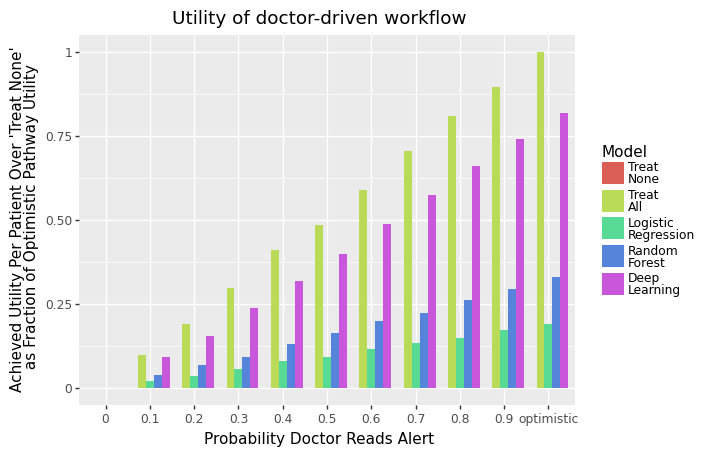


==== Thresholded + Specialist Cap (2) ====
Loading file from ../secure/pad/output/doctor_False_2_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_pad_doctor_.pkl


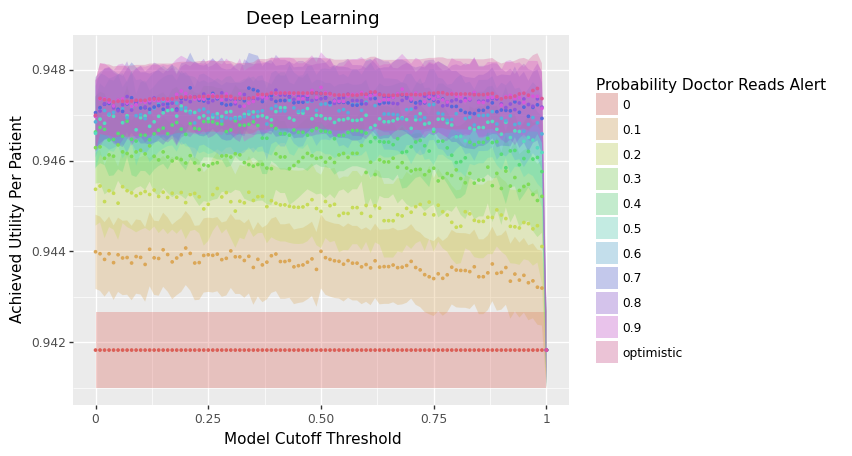

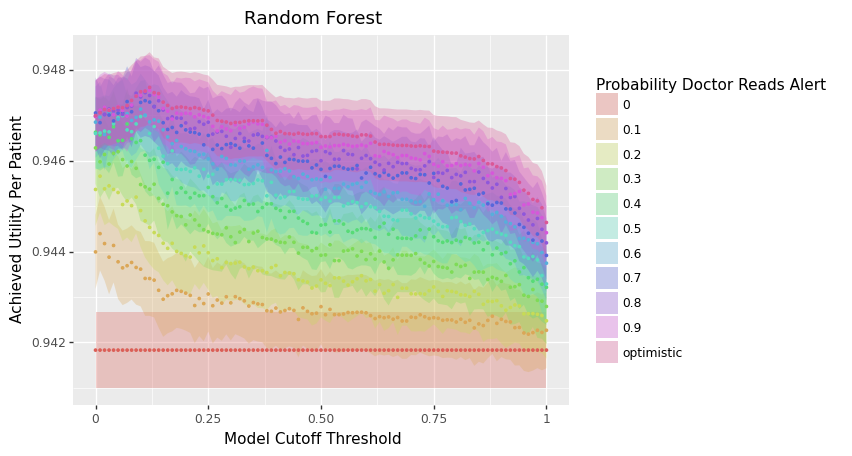

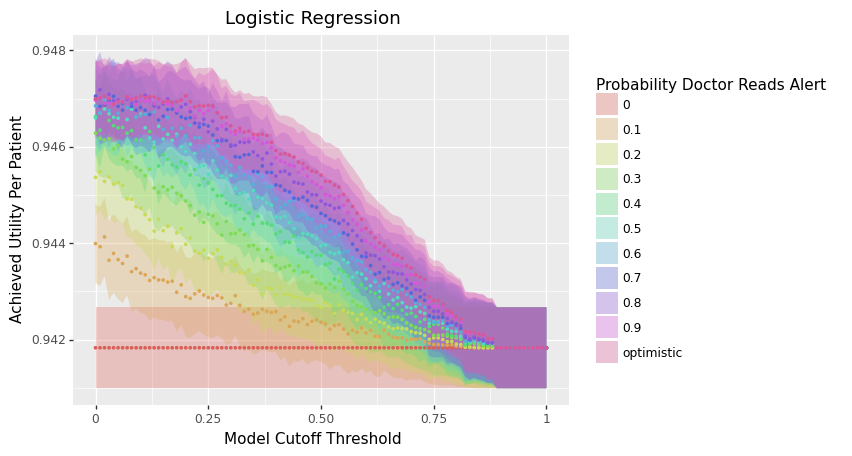

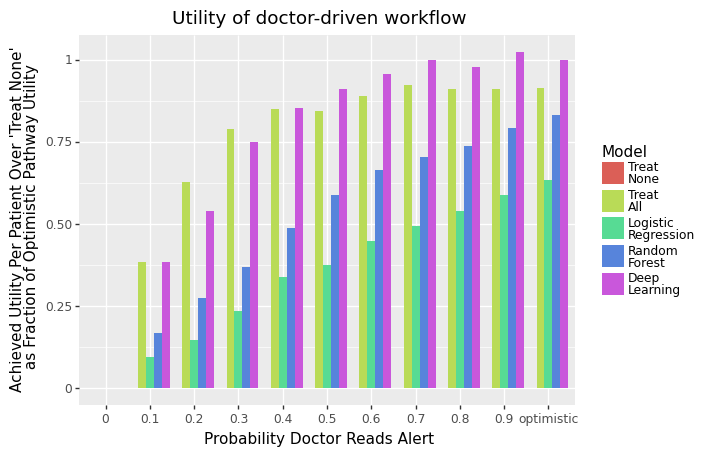


==== Thresholded + Specialist Cap (5) ====
Loading file from ../secure/pad/output/doctor_False_5_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_pad_doctor_.pkl


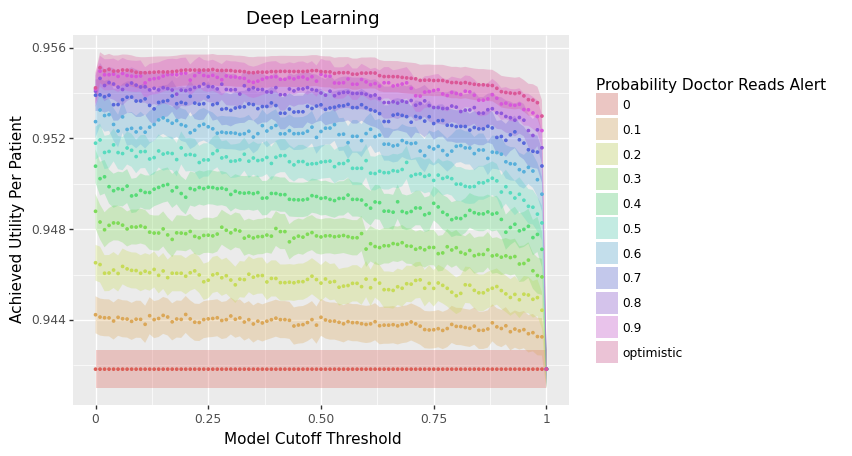

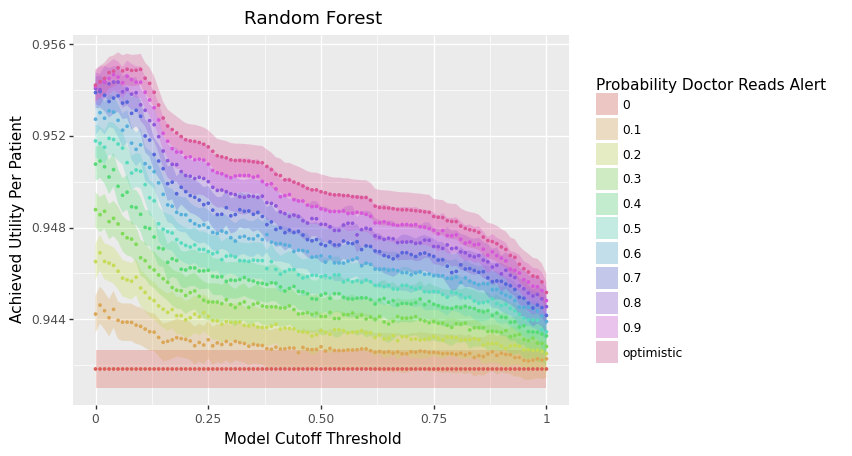

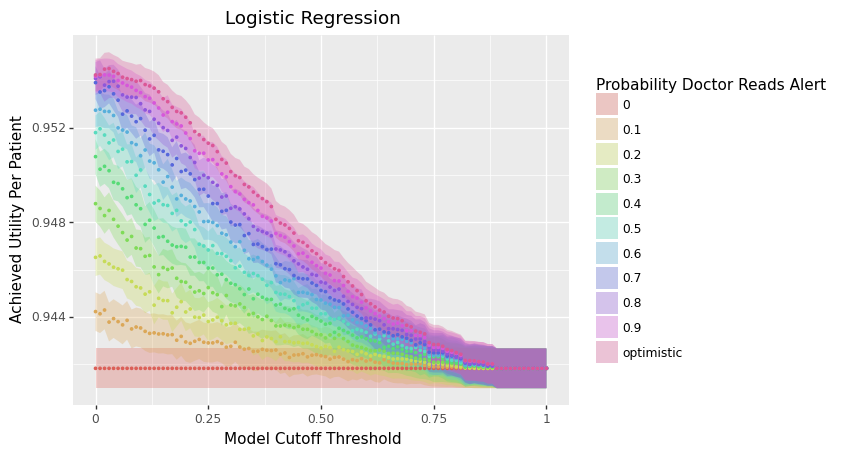

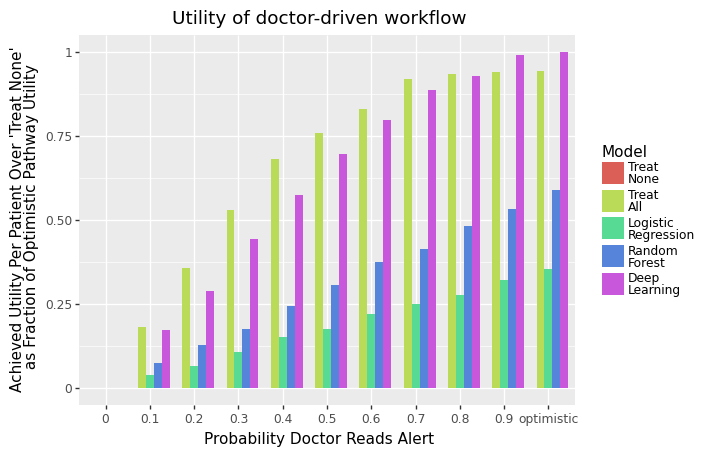

In [12]:
# Thresholded screening, unlimited specialist
print("==== Thresholded + Specialist Unlimited ====")
simulate_doctor_workflow(copy.deepcopy(all_patients),
                        [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, ],
                        specialist_capacity=None,
                        is_ranked_screening=False,
                        path_to_yaml=PATH_TO_DOCTOR_YAML)

# Thresholded screening, capped specialist
print("==== Thresholded + Specialist Cap (2) ====")
simulate_doctor_workflow(copy.deepcopy(all_patients),
                        [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, ],
                        specialist_capacity=2,
                        is_ranked_screening=False,
                        path_to_yaml=PATH_TO_DOCTOR_YAML)

# Thresholded screening, capped specialist
print("==== Thresholded + Specialist Cap (5) ====")
simulate_doctor_workflow(copy.deepcopy(all_patients),
                        [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, ],
                        specialist_capacity=5,
                        is_ranked_screening=False,
                        path_to_yaml=PATH_TO_DOCTOR_YAML)

# DL Model - Doctor-Driven v. Nurse-Driven Utilities

In [13]:
def plot_doctor_v_nurse(patients: list[sim.Patient], specialist_capacity: int):
    nurse_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
    pkl_name: str = ("nurse_" +
                     str(True) + "_" +
                     str(specialist_capacity) + "_" +
                     "-".join([str(x) for x in nurse_values]) + "_" +
                     str(len(patients)) + "_" +
                     ".pkl")
    pkl_path: str = os.path.join(PATH_TO_OUTPUT_FOLDER, pkl_name)
    if os.path.exists(pkl_path):
        print(f"Loading file from {pkl_path}")
        with open(pkl_path, 'rb') as fd:
            results = pickle.load(fd)
        m2r_nurse, b2r_nurse = results['model'], results['baseline']
    else:
        # Nurse
        labels = [f"{x}" for x in nurse_values ]
        settings = [{
                        'nurse_capacity' : {
                            'type' : 'resource',
                            'init_amount' : x,
                            'max_amount' : x,
                            'refill_amount' : x,
                            'refill_duration' : 1,
                        },
                        'specialist_capacity' : {
                            'type' : 'resource',
                            'init_amount' : specialist_capacity,
                            'max_amount' : specialist_capacity,
                            'refill_amount' : specialist_capacity,
                            'refill_duration' : 1,
                        },
                    } for x in nurse_values ]
        m2r_nurse, b2r_nurse = pad.run_test(patients,
                                                labels,
                                                settings,
                                                MODELS,
                                                THRESHOLDS, # Only need to test one threshold because using ranked threshold
                                                PATH_TO_NURSE_YAML,
                                                PATH_TO_PATIENT_PROPERTIES,
                                                is_patient_sort_by_y_hat=True,
                                                func_setup_optimistic=pad.setup_nurse_optimistic)
        with open(pkl_path, 'wb') as fd:
            pickle.dump({
                'model': m2r_nurse,
                'baseline': b2r_nurse,
            }, fd)

    # Doctor
    doctor_values = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, ]
    pkl_name: str = ("doctor_" +
                     str(False) + "_" +
                     str(specialist_capacity) + "_" +
                     "-".join([str(x) for x in doctor_values]) + "_" +
                     str(len(patients)) + "_" +
                     ".pkl")
    pkl_path: str = os.path.join(PATH_TO_OUTPUT_FOLDER, pkl_name)
    if os.path.exists(pkl_path):
        print(f"Loading file from {pkl_path}")
        with open(pkl_path, 'rb') as fd:
            results = pickle.load(fd)
        m2r_doctor, b2r_doctor = results['model'], results['baseline']
    else:
        labels = [f"{x}" for x in doctor_values ]
        settings = [{
                        'prob_pad_alert_is_read' : {
                            'type' : 'scalar',
                            'value' : x,
                        },
                        'specialist_capacity' : {
                            'type' : 'resource',
                            'init_amount' : specialist_capacity,
                            'max_amount' : specialist_capacity,
                            'refill_amount' : specialist_capacity,
                            'refill_duration' : 1,
                        },
                    } for x in doctor_values ]
        m2r_doctor, b2r_doctor = pad.run_test(copy.deepcopy(all_patients),
                                                labels,
                                                settings,
                                                MODELS,
                                                THRESHOLDS,
                                                PATH_TO_DOCTOR_YAML,
                                                PATH_TO_PATIENT_PROPERTIES,
                                                is_patient_sort_by_y_hat=False,
                                                func_setup_optimistic=pad.setup_doctor_optimistic)
        with open(pkl_path, 'wb') as fd:
            pickle.dump({
                'model': m2r_doctor,
                'baseline': b2r_doctor,
            }, fd)

    df_nurse = pad.plot_helper(m2r_nurse, b2r_nurse)
    df_doctor = pad.plot_helper(m2r_doctor, b2r_doctor)

    # Calculate baselines
    n_none, d_none = df_nurse[df_nurse['model'] == 'none']['y'].max(), df_doctor[df_doctor['model'] == 'none']['y'].max()
    n_all, d_all = df_nurse[df_nurse['model'] == 'all']['y'].max(), df_doctor[df_doctor['model'] == 'all']['y'].max()
    assert (n_none == d_none), "n_none != d_none"
    assert (n_all == d_all), "n_all != d_all"
    baseline = min([n_none, n_all])
    # Calculate optimistic
    n_optimistic, d_optimistic = df_nurse[df_nurse['label'] == 'optimistic']['y'].max(), df_doctor[df_doctor['label'] == 'optimistic']['y'].max()
    assert (n_optimistic == d_optimistic), "n_optimistic != d_optimistic"
    utility_optimistic = n_optimistic
    # We scale everything by the 'optimistic' pathway that yields the max utility (since there may be multiple 'optimistic' rows)
    df_nurse['y'] = (df_nurse['y'] - baseline) / (utility_optimistic - baseline)
    df_doctor['y'] = (df_doctor['y'] - baseline) / (utility_optimistic - baseline)

    # Plot
    for m in MODELS:
        fig, ax = plt.subplots(figsize=(10,10))
        n = df_nurse[(df_nurse['model'] == m) & (df_nurse['label'] != 'optimistic')]
        d = df_doctor[(df_doctor['model'] == m) & (df_doctor['label'] != 'optimistic')]
        d['label'] = d['label'].astype(float)
        nurse_colors = cm.get_cmap('Blues', n.shape[0])(np.linspace(0.5, 1, n.shape[0]))
        for idx, (_, row) in enumerate(n.iterrows()):
            plt.plot([d['label'].min(), d['label'].max()], 
                    [row['y'], row['y']], 
                    '--', 
                    color=nurse_colors[idx])
            plt.text(.8, row['y'], f"Nurse Capacity={row['label']}", backgroundcolor='white')
        if m == 'dl':
            model_name = 'Deep Learning'
        elif m == 'rf':
            model_name = 'Random Forest'
        elif m == 'lr':
            model_name = 'Logistic Regression'
        plt.plot(d['label'], d['y'])
        plt.ylabel('Achieved Utility Over "Treat None" Baseline as Fraction of Optimistic Pathway\'s Utility')
        plt.xlabel('Probability Doctor Reads EHR Alert')
        plt.title(f"Contrasting the utility achieved under a nurse-driven v. doctor-driven workflow\nModel = {model_name} | Specialist capacity = {specialist_capacity}")
        plt.margins(x=0)
        plt.ylim(0, 1)
        blue_patch = mpatches.Patch(color=nurse_colors[-1], label='Nurse-driven workflow')
        red_patch = mpatches.Patch(color='tab:red', label='Doctor-driven Workflow')
        ax.legend(handles=[blue_patch, red_patch], loc='upper left', facecolor='white')
        plt.show()
    return df_nurse, df_doctor

Loading file from ../secure/pad/output/nurse_True_2_0-1-2-3-4-5-6-7-8-9-10_17515_.pkl
Loading file from ../secure/pad/output/doctor_False_2_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_.pkl


/var/folders/l3/6s68f1xn5d59vwpf4qtswbtc0000gn/T/ipykernel_65453/497442656.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


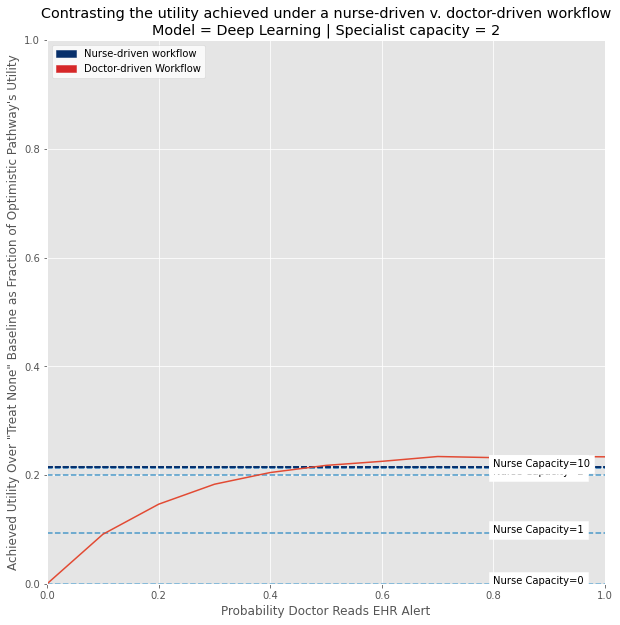

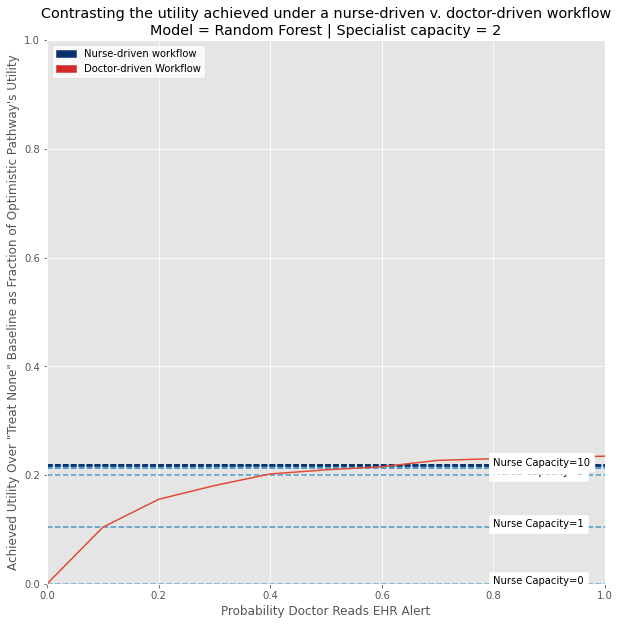

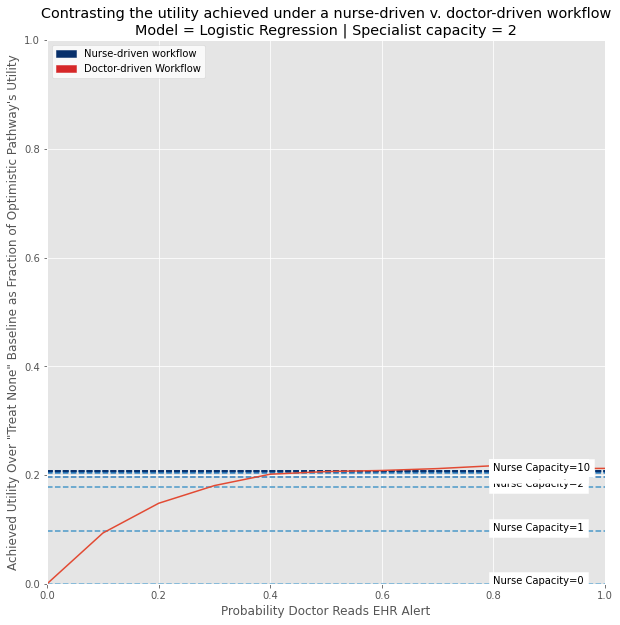

Loading file from ../secure/pad/output/nurse_True_5_0-1-2-3-4-5-6-7-8-9-10_17515_.pkl
Loading file from ../secure/pad/output/doctor_False_5_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_.pkl


/var/folders/l3/6s68f1xn5d59vwpf4qtswbtc0000gn/T/ipykernel_65453/497442656.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


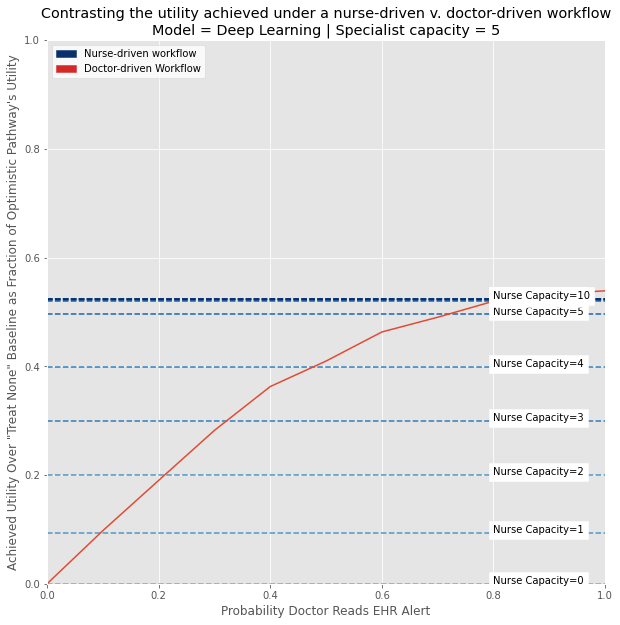

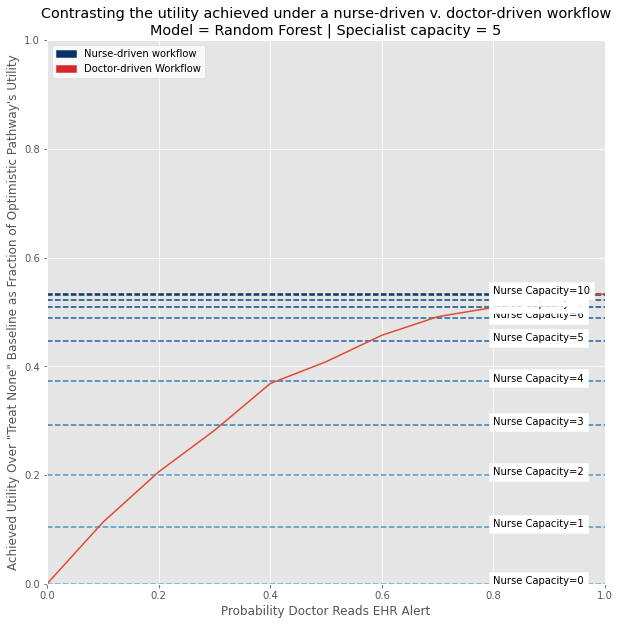

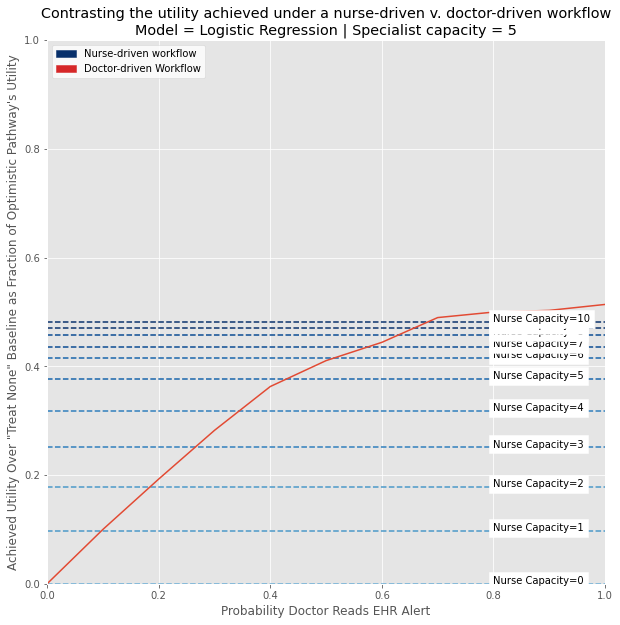

Loading file from ../secure/pad/output/nurse_True_1000000000.0_0-1-2-3-4-5-6-7-8-9-10_17515_.pkl
Loading file from ../secure/pad/output/doctor_False_1000000000.0_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_.pkl


/var/folders/l3/6s68f1xn5d59vwpf4qtswbtc0000gn/T/ipykernel_65453/497442656.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


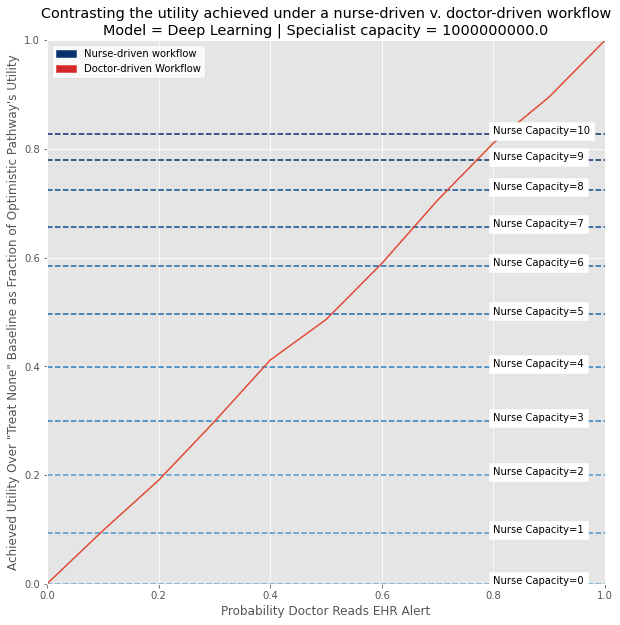

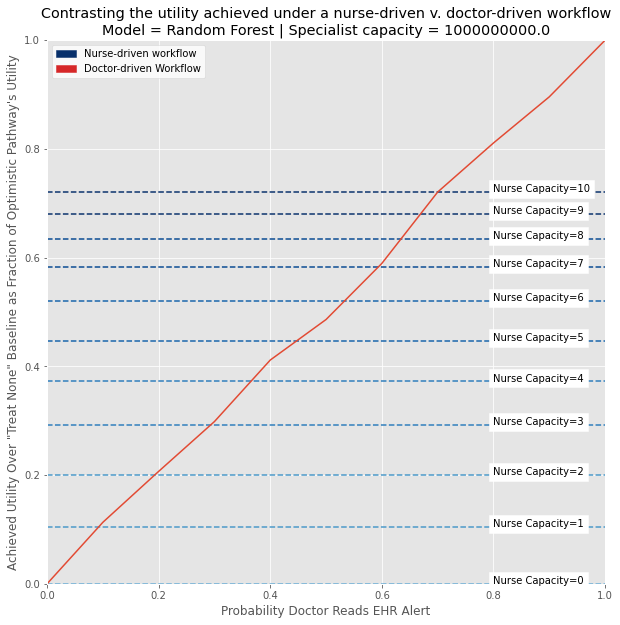

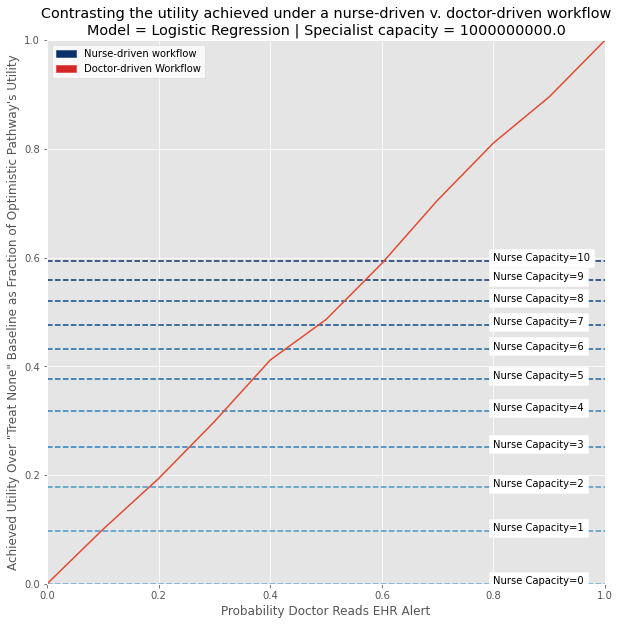

In [14]:
df_nurse_2, df_doctor_2 = plot_doctor_v_nurse(copy.deepcopy(all_patients), 2)
df_nurse_5, df_doctor_5 = plot_doctor_v_nurse(copy.deepcopy(all_patients), 5)
df_nurse_all, df_doctor_all = plot_doctor_v_nurse(copy.deepcopy(all_patients), 1e9)

# Model Performance

In [15]:
# For the purposes of ROC curves, set these baseline utilities
UTILITIES = {
    'tp' : -0.35,
    'fp' : -0.2,
    'tn' : 0,
    'fn' : -1,
}

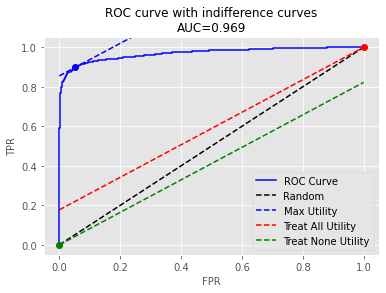

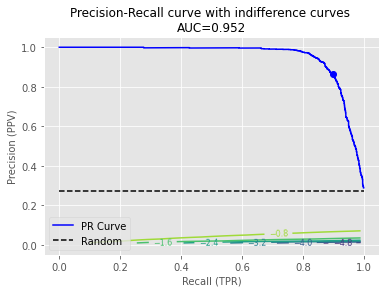

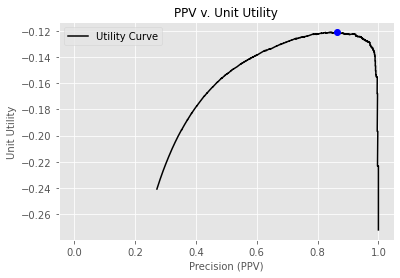

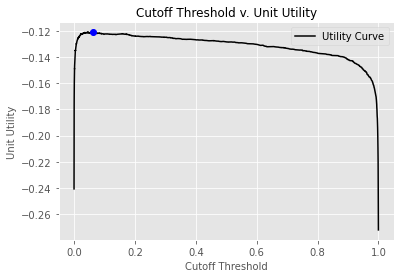

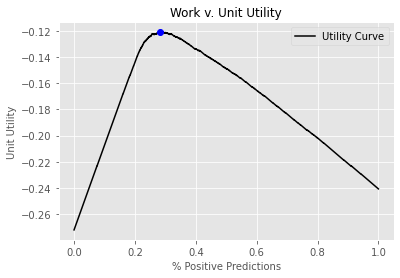

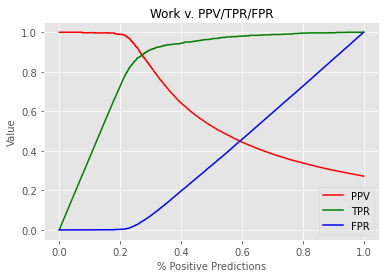

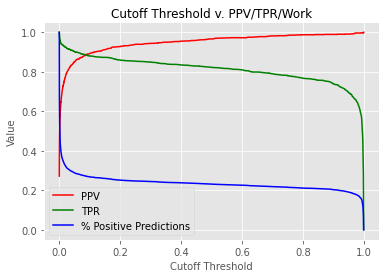

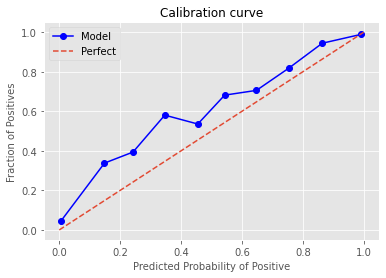

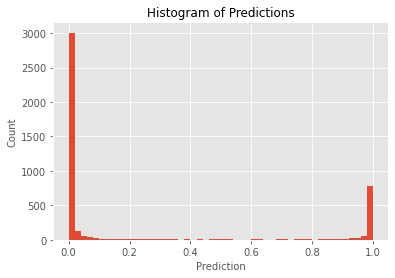

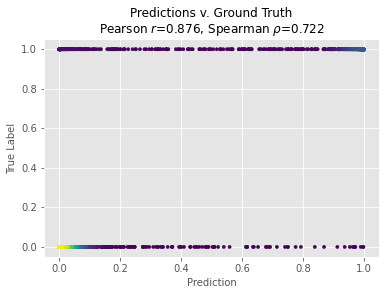

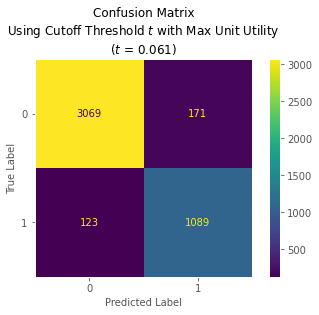

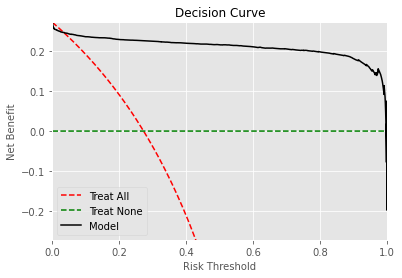

In [16]:
# Deep Learning
plot.make_model_utility_plots(df_merged.rename(columns = { 'y_hat_dl' : 'y_hat' }), 
                              UTILITIES, 
                              is_show = True)

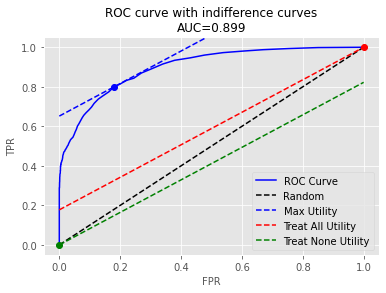

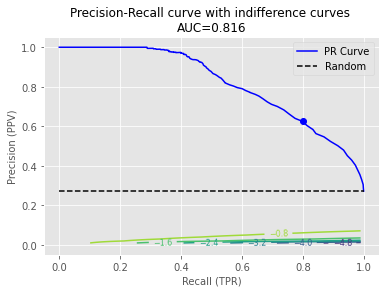

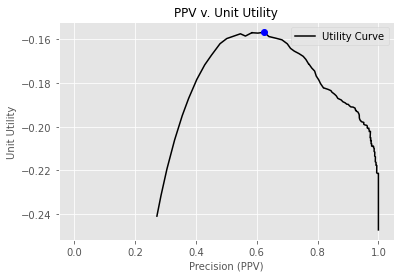

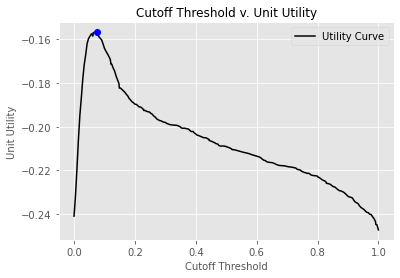

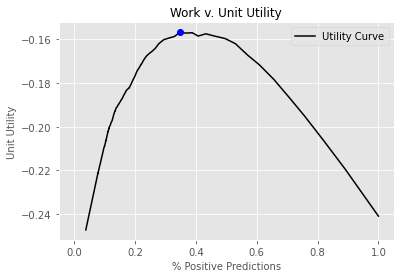

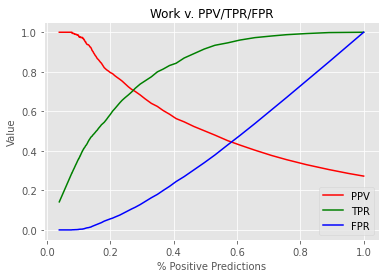

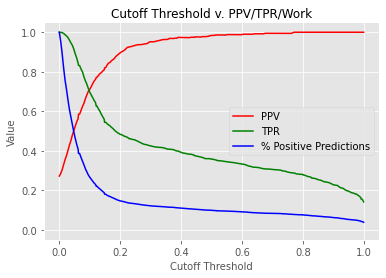

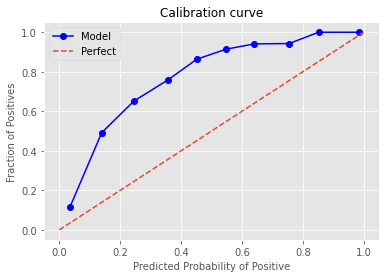

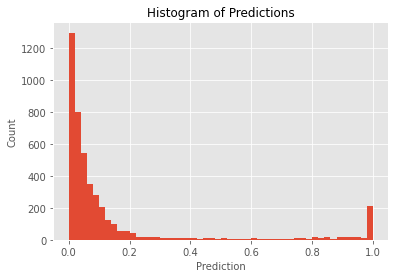

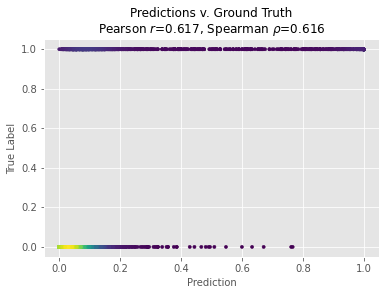

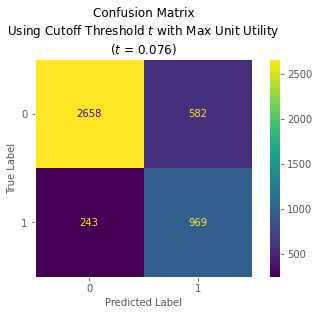

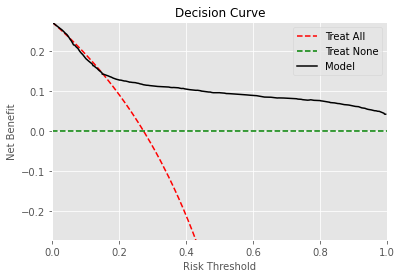

In [17]:
# Random Forest
plot.make_model_utility_plots(df_merged.rename(columns = { 'y_hat_rf' : 'y_hat' }), 
                              UTILITIES, 
                              is_show = True)

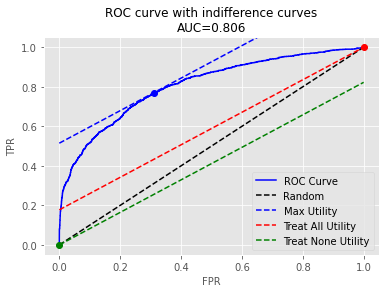

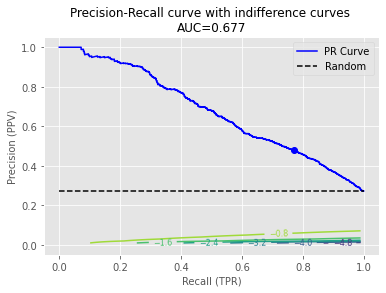

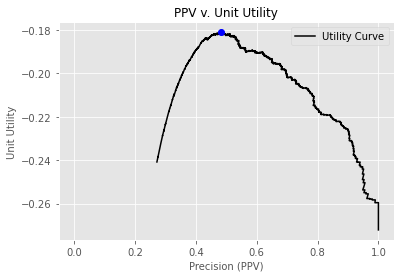

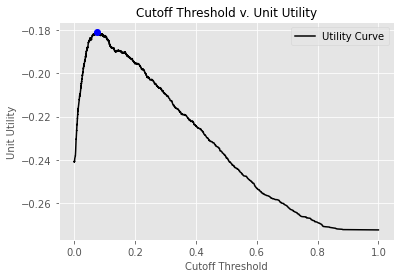

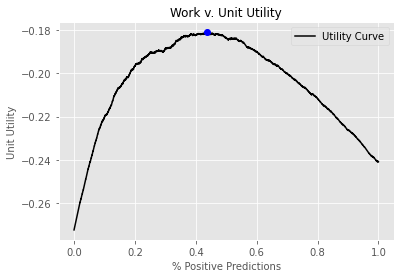

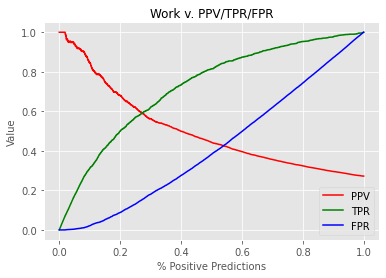

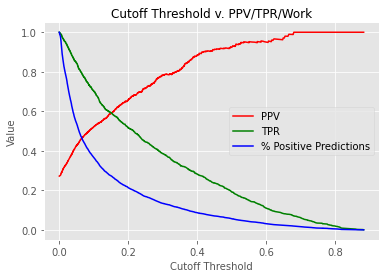

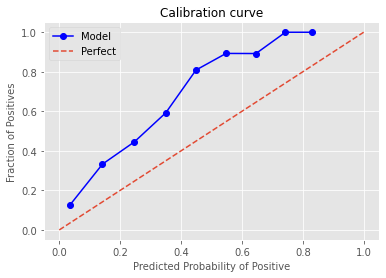

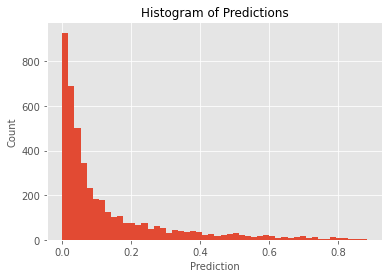

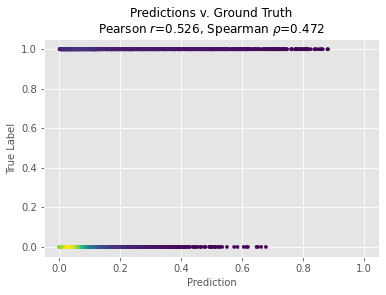

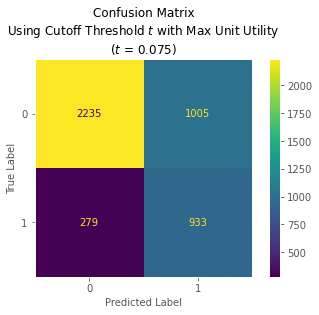

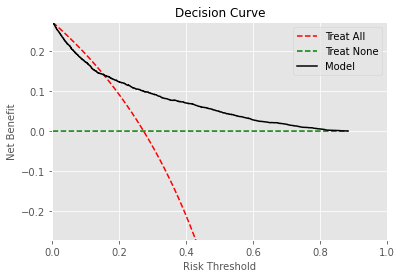

In [18]:
# Logistic Regression
plot.make_model_utility_plots(df_merged.rename(columns = { 'y_hat_lr' : 'y_hat' }), 
                              UTILITIES, 
                              is_show = True)

# Everything table

In [ ]:
settings = [0, .05, .1, .15, .2, .25 ]
abi_test_treat_immediately_threshold = [ 0, 0.7, 0.75, 0.8, 0.85, 0.9, ]
specialist_capacity = [ 3, ]
specialist_days_in_office = [ list(range(1, 6)), ] # Test:5 days/week
labels = [f"{w}|{x}|{y}|{z}" for w in settings for x in abi_test_treat_immediately_threshold for y in specialist_capacity for z in specialist_days_in_office]
settings = [{
                'prob_pad_alert_is_read' : {
                    **simulation.variables['prob_pad_alert_is_read'],
                    'value' : w,
                },
                'abi_test_treat_immediately_threshold' : {
                    **simulation.variables['abi_test_treat_immediately_threshold'],
                    'value' : x,
                },
                'specialist_capacity' : {
                    **simulation.variables['specialist_capacity'],
                    'init_amount' : y,
                    'max_amount' : y,
                    'refill_amount' : y,
                },
                'specialist_days_in_office' : {
                    **simulation.variables['specialist_days_in_office'],
                    'value' : z,
                },
            } for w in settings for x in abi_test_treat_immediately_threshold for y in specialist_capacity for z in specialist_days_in_office ]
model_2_result_alert_immediate, baseline_2_result_alert_immediate = pad.run_test(copy.deepcopy(all_patients), 
                                                                                 labels,
                                                                                 settings,
                                                                                 MODELS,
                                                                                 THRESHOLDS,
                                                                                 PATH_TO_DOCTOR_YAML,
                                                                                 PATH_TO_PATIENT_PROPERTIES,
                                                                                 is_patient_sort_by_y_hat=True,
                                                                                 func_setup_optimistic=pad.setup_doctor_optimistic)
